In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import sklearn
import os

In [2]:
%autosave 60

Autosaving every 60 seconds


In [3]:
import os
import pandas as pd
from charset_normalizer import from_path

input_folder1 = r"/content/dataset1"
input_folder2 = r"/content/dataset2"
output_csv1_path = "output_dataset1.csv"
output_csv2_path = "output_dataset2.csv"

def detect_encoding(file_path):
    result = from_path(file_path).best()
    return result.encoding

def process_folder(folder_path):
    all_data = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            encoding = detect_encoding(file_path)
            print(f"Кодировка файла {filename}: {encoding}")
            with open(file_path, 'r', encoding=encoding) as file:
                lines = file.readlines()
                for line in lines:
                    row = line.strip().split('\t')
                    all_data.append(row)
    return all_data

if os.path.exists(input_folder1):
    print(f"Обработка датасета 1: {input_folder1}")
    data1 = process_folder(input_folder1)
    df1 = pd.DataFrame(data1)
    df1.to_csv(output_csv1_path, index=False, header=False)
    print(f"Данные датасета 1 сохранены в {output_csv1_path}")
else:
    print(f"Папка {input_folder1} не найдена. Проверьте путь.")

if os.path.exists(input_folder2):
    print(f"Обработка датасета 2: {input_folder2}")
    data2 = process_folder(input_folder2)
    df2 = pd.DataFrame(data2)
    df2.to_csv(output_csv2_path, index=False, header=False)
    print(f"Данные датасета 2 сохранены в {output_csv2_path}")
else:
    print(f"Папка {input_folder2} не найдена. Проверьте путь.")

Обработка датасета 1: /content/dataset1
Кодировка файла tpMatrix.txt: ascii
Кодировка файла rtMatrix.txt: ascii
Кодировка файла wslist.txt: cp1250
Кодировка файла readme.txt: utf_8
Кодировка файла userlist.txt: ascii
Данные датасета 1 сохранены в output_dataset1.csv
Обработка датасета 2: /content/dataset2
Кодировка файла tpdata.txt: ascii
Кодировка файла readme.txt: utf_8
Кодировка файла rtdata.txt: ascii
Данные датасета 2 сохранены в output_dataset2.csv


In [4]:
df1 = pd.read_csv('/content/output_dataset1.csv', header=None)
df2 = pd.read_csv('/content/output_dataset2.csv', header=None)

df1 = df1.drop_duplicates()
df2 = df2.drop_duplicates()

df1 = df1.dropna()
df2 = df2.dropna()

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in df1.select_dtypes(include=[np.number]).columns:
    df1 = remove_outliers(df1, col)

for col in df2.select_dtypes(include=[np.number]).columns:
    df2 = remove_outliers(df2, col)

df1.to_csv('cleaned_dataset1.csv', index=False, header=False)
df2.to_csv('cleaned_dataset2.csv', index=False, header=False)

print("Данные очищены и сохранены в cleaned_dataset1.csv и cleaned_dataset2.csv")

/tmp/ipython-input-3194966315.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('/content/output_dataset1.csv', header=None)


Данные очищены и сохранены в cleaned_dataset1.csv и cleaned_dataset2.csv


In [5]:
from sklearn.preprocessing import MinMaxScaler

df1 = pd.read_csv('/content/cleaned_dataset1.csv', header=None)
df2 = pd.read_csv('/content/cleaned_dataset2.csv', header=None)

response_time_col = 0
throughput_col = 1

if response_time_col in df1.columns and throughput_col in df1.columns:
    min_max_scaler = MinMaxScaler()
    df1[[response_time_col, throughput_col]] = min_max_scaler.fit_transform(df1[[response_time_col, throughput_col]])

if response_time_col in df2.columns and throughput_col in df2.columns:
    min_max_scaler = MinMaxScaler()
    df2[[response_time_col, throughput_col]] = min_max_scaler.fit_transform(df2[[response_time_col, throughput_col]])

df1.to_csv('normalized_dataset1.csv', index=False, header=False)
df2.to_csv('normalized_dataset2.csv', index=False, header=False)

print("Данные нормализованы и сохранены в normalized_dataset1.csv и normalized_dataset2.csv")

Данные нормализованы и сохранены в normalized_dataset1.csv и normalized_dataset2.csv


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

df1 = pd.read_csv('/content/normalized_dataset1.csv', header=None)
df2 = pd.read_csv('/content/normalized_dataset2.csv', header=None)

X1 = df1.iloc[:, :-1]  # Все столбцы, кроме последнего (признаки)
y1 = df1.iloc[:, -1]    # Последний столбец (целевая переменная)
X2 = df2.iloc[:, :-1]   # Все столбцы, кроме последнего (признаки)
y2 = df2.iloc[:, -1]    # Последний столбец (целевая переменная)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

X1_train['split'] = 'train'
X1_test['split'] = 'test'
X2_train['split'] = 'train'
X2_test['split'] = 'test'

train_test_data1 = pd.concat([X1_train, y1_train], axis=1)
train_test_data1 = pd.concat([train_test_data1, pd.concat([X1_test, y1_test], axis=1)])

train_test_data2 = pd.concat([X2_train, y2_train], axis=1)
train_test_data2 = pd.concat([train_test_data2, pd.concat([X2_test, y2_test], axis=1)])

train_test_data1.to_csv('train_test_data1.csv', index=False)
train_test_data2.to_csv('train_test_data2.csv', index=False)

print("Данные объединены и сохранены в train_test_data1.csv и train_test_data2.csv.")

Данные объединены и сохранены в train_test_data1.csv и train_test_data2.csv.


In [7]:
import pandas as pd
import numpy as np

train_test_data1 = pd.read_csv('/content/train_test_data1.csv')
train_test_data2 = pd.read_csv('/content/train_test_data2.csv')

train_test_data1['user_id'] = np.random.randint(1, 100, size=len(train_test_data1))
train_test_data2['user_id'] = np.random.randint(1, 100, size=len(train_test_data2))

train_test_data1['rating'] = np.random.randint(1, 6, size=len(train_test_data1))
train_test_data2['rating'] = np.random.randint(1, 6, size=len(train_test_data2))

train_test_data1['feature2'] = np.random.randint(1, 100, size=len(train_test_data1))
train_test_data2['feature2'] = np.random.randint(1, 100, size=len(train_test_data2))

print("train_test_data1:")
print(train_test_data1)

print("\ntrain_test_data2:")
print(train_test_data2)

def save_updated_dataset(dataset, filename):
    dataset.to_csv(filename, index=False)
    print(f"Датасет сохранён в файл: {filename}")

save_updated_dataset(train_test_data1, 'train_test_data1.csv')
save_updated_dataset(train_test_data2, 'train_test_data2.csv')

train_test_data1:
          0         1      2      3      4      5      6      7      8      9  \
0  1.000000  0.679245  0.329  0.307  0.308  0.826  0.706  1.073  0.562  1.001   
1  0.000000  0.000000  0.258  0.235  0.236  0.415  0.533  0.820  0.399  0.584   
2  0.372197  1.000000  0.356  0.361  0.319  0.578  0.740  1.143  0.580  0.845   

   ...   5819   5820   5821   5822   5823  split   5824  user_id  rating  \
0  ...  0.235  0.359  0.248  0.364  0.239  train  0.242       93       3   
1  ...  0.188  0.141  0.144  0.142  0.174  train  0.141       95       4   
2  ...  0.243  0.244  0.238  0.248  0.244   test  0.241       20       2   

   feature2  
0        81  
1        73  
2        60  

[3 rows x 5829 columns]

train_test_data2:
          split                      0  user_id  rating  feature2
0         train  26 384 10 0.107201815       79       5        60
1         train        44 1050 27 20.0       46       2        38
2         train        6 3066 29 0.179       45       

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Загружаем данные из файлов
train_test_data1 = pd.read_csv('/content/train_test_data1.csv')
train_test_data2 = pd.read_csv('/content/train_test_data2.csv')

# Проверяем наличие столбцов 'feature1' и 'feature2'
if 'feature1' not in train_test_data1.columns:
    train_test_data1['feature1'] = np.random.rand(len(train_test_data1))
if 'feature2' not in train_test_data1.columns:
    train_test_data1['feature2'] = np.random.rand(len(train_test_data1))

if 'feature1' not in train_test_data2.columns:
    train_test_data2['feature1'] = np.random.rand(len(train_test_data2))
if 'feature2' not in train_test_data2.columns:
    train_test_data2['feature2'] = np.random.rand(len(train_test_data2))

# Проверяем данные
print("Данные train_test_data1:")
print(train_test_data1.head())

print("\nДанные train_test_data2:")
print(train_test_data2.head())

def simulate_cold_start(data, test_size=0.2, keep_ratios=0.1):
    user_ids = data['user_id'].unique()
    new_users = np.random.choice(user_ids, size=int(test_size * len(user_ids)), replace=False)
    new_users_data = data[data['user_id'].isin(new_users)].copy()
    mask = np.random.rand(len(new_users_data)) > keep_ratios
    new_users_data.loc[mask, 'rating'] = np.nan
    existing_users_data = data[~data['user_id'].isin(new_users)]
    return new_users_data, existing_users_data

new_users_data1, existing_users_data1 = simulate_cold_start(train_test_data1)
new_users_data2, existing_users_data2 = simulate_cold_start(train_test_data2)

print("\nРаспределение для train_test_data1:")
print(f"Новые пользователи: {len(new_users_data1)} записей")
print(f"Существующие пользователи: {len(existing_users_data1)} записей")

print("\nРаспределение для train_test_data2:")
print(f"Новые пользователи: {len(new_users_data2)} записей")
print(f"Существующие пользователи: {len(existing_users_data2)} записей")

# Используем feature1 и feature2 как признаки, а rating как целевую переменную
X_train = existing_users_data1[['feature1', 'feature2']]
y_train = existing_users_data1['rating']

X_test = new_users_data1[['feature1', 'feature2']]
y_test = new_users_data1['rating']

# Проверяем, что X_test не пустой
if len(X_test) == 0:
    print("\nОшибка: Нет данных для тестирования (X_test пустой).")
    print("Возможные причины:")
    print("- В данных недостаточно новых пользователей.")
    print("- Все рейтинги новых пользователей были удалены.")
    print("Добавляем случайные данные для тестирования...")

    # Добавляем случайные данные для новых пользователей
    X_test = np.random.rand(10, 2)  # 10 строк, 2 признака (feature1 и feature2)
    y_test = np.random.randint(1, 6, size=10)  # Случайные рейтинги от 1 до 5
    print("\nСгенерировано 10 случайных строк для тестирования.")
else:
    print("\nДанные для тестирования найдены.")

# Обучаем модель (например, RandomForestClassifier)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Предсказания на данных новых пользователей
y_pred = model.predict(X_test)

# Оценка модели (если есть часть рейтингов для проверки)
if len(y_test) > 0:
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nТочность модели на новых пользователях: {accuracy:.2f}")
else:
    print("\nНет данных для оценки точности (все рейтинги новых пользователей отсутствуют).")

Данные train_test_data1:
          0         1      2      3      4      5      6      7      8      9  \
0  1.000000  0.679245  0.329  0.307  0.308  0.826  0.706  1.073  0.562  1.001   
1  0.000000  0.000000  0.258  0.235  0.236  0.415  0.533  0.820  0.399  0.584   
2  0.372197  1.000000  0.356  0.361  0.319  0.578  0.740  1.143  0.580  0.845   

   ...   5820   5821   5822   5823  split   5824  user_id  rating  feature2  \
0  ...  0.359  0.248  0.364  0.239  train  0.242       93       3        81   
1  ...  0.141  0.144  0.142  0.174  train  0.141       95       4        73   
2  ...  0.244  0.238  0.248  0.244   test  0.241       20       2        60   

   feature1  
0  0.427533  
1  0.383111  
2  0.257228  

[3 rows x 5830 columns]

Данные train_test_data2:
   split                      0  user_id  rating  feature2  feature1
0  train  26 384 10 0.107201815       79       5        60  0.996253
1  train        44 1050 27 20.0       46       2        38  0.110480
2  train        6 3

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [9]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model

# Загрузка данных
hofstede_file_path = ('/content/Hofstedes Dimensions Data.xlsx')
hofstede_df = pd.read_excel(hofstede_file_path, sheet_name='6 dimensions for website')

# Вычисление дисперсии для культурных измерений
variance_data = {
    'pdi': hofstede_df['pdi'].var(),
    'idv': hofstede_df['idv'].var(),
    'mas': hofstede_df['mas'].var(),
    'uai': hofstede_df['uai'].var(),
    'ltowvs': hofstede_df['ltowvs'].var(),
    'ivr': hofstede_df['ivr'].var()
}
variance_df = pd.Series(variance_data)

# Загрузка данных пользователей
users_file_path = '/content/data.csv'
qos_data = pd.read_csv(users_file_path)

print("Исходные данные:")
print(qos_data.head())

Исходные данные:
   [User ID]    [IP Address]      [Country]    [IP No.]  \
0          0  12.108.127.138  United States   208437130   
1          1    12.46.129.15  United States   204374287   
2          2    122.1.115.91          Japan  2046915419   
3          3    128.10.19.52  United States  2148143924   
4          4    128.10.19.53  United States  2148143925   

                                    [AS]  [Latitude]  [Longitude]  
0             AS7018 AT&T Services, Inc.     38.0000     -97.0000  
1             AS7018 AT&T Services, Inc.     38.0464    -122.2300  
2  AS4713 NTT Communications Corporation     35.6850     139.7514  
3                 AS17 Purdue University     40.4249     -86.9162  
4                 AS17 Purdue University     40.4249     -86.9162  


In [10]:
# Преобразование данных в числовой формат
qos_data['[User ID]'] = pd.to_numeric(qos_data['[User ID]'], errors='coerce')
qos_data['[IP Address]'] = pd.to_numeric(qos_data['[IP Address]'], errors='coerce')
qos_data['[Country]'] = pd.to_numeric(qos_data['[Country]'], errors='coerce')
qos_data['[IP No.]'] = pd.to_numeric(qos_data['[IP No.]'], errors='coerce')
qos_data['[AS]'] = pd.to_numeric(qos_data['[AS]'], errors='coerce')
qos_data['[Latitude]'] = pd.to_numeric(qos_data['[Latitude]'], errors='coerce')
qos_data['[Longitude]'] = pd.to_numeric(qos_data['[Longitude]'], errors='coerce')

print("\nДанные после преобразования в числовой формат:")
print(qos_data.head())


Данные после преобразования в числовой формат:
   [User ID]  [IP Address]  [Country]    [IP No.]  [AS]  [Latitude]  \
0          0           NaN        NaN   208437130   NaN     38.0000   
1          1           NaN        NaN   204374287   NaN     38.0464   
2          2           NaN        NaN  2046915419   NaN     35.6850   
3          3           NaN        NaN  2148143924   NaN     40.4249   
4          4           NaN        NaN  2148143925   NaN     40.4249   

   [Longitude]  
0     -97.0000  
1    -122.2300  
2     139.7514  
3     -86.9162  
4     -86.9162  


In [11]:
# Удаление столбцов, полностью состоящих из NaN
columns_with_all_nan = [col for col in qos_data.columns if qos_data[col].isna().all()]
qos_data = qos_data.drop(columns=columns_with_all_nan)

if columns_with_all_nan:
    print(f"\nУдалены столбцы, полностью состоящие из NaN: {columns_with_all_nan}")
else:
    print("\nСтолбцы, полностью состоящие из NaN, отсутствуют.")

print("\nДанные после удаления столбцов с NaN:")
print(qos_data.head())


Удалены столбцы, полностью состоящие из NaN: ['[IP Address]', '[Country]', '[AS]']

Данные после удаления столбцов с NaN:
   [User ID]    [IP No.]  [Latitude]  [Longitude]
0          0   208437130     38.0000     -97.0000
1          1   204374287     38.0464    -122.2300
2          2  2046915419     35.6850     139.7514
3          3  2148143924     40.4249     -86.9162
4          4  2148143925     40.4249     -86.9162


In [12]:
# Разделение данных на числовые и нечисловые столбцы
qos_data_numeric = qos_data.select_dtypes(include=[np.number])
qos_data_non_numeric = qos_data.select_dtypes(exclude=[np.number])

print("\nЧисловые столбцы:")
print(qos_data_numeric.head())

print("\nНечисловые столбцы:")
print(qos_data_non_numeric.head())


Числовые столбцы:
   [User ID]    [IP No.]  [Latitude]  [Longitude]
0          0   208437130     38.0000     -97.0000
1          1   204374287     38.0464    -122.2300
2          2  2046915419     35.6850     139.7514
3          3  2148143924     40.4249     -86.9162
4          4  2148143925     40.4249     -86.9162

Нечисловые столбцы:
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]


In [13]:
# Проверка данных на пропущенные значения
if qos_data_numeric.isnull().any().any():
    print("\nОбнаружены пропущенные значения. Заполняем с использованием KNNImputer...")

    # Использование KNNImputer для заполнения пропущенных значений
    imputer = KNNImputer(n_neighbors=5)  # Количество соседей можно настроить
    qos_data_imputed = imputer.fit_transform(qos_data_numeric)

    # Преобразование обратно в DataFrame
    qos_data_imputed_df = pd.DataFrame(qos_data_imputed, columns=qos_data_numeric.columns)

    print("\nДанные после заполнения пропусков:")
    print(qos_data_imputed_df.head())

    # Объединение с нечисловыми столбцами
    if not qos_data_non_numeric.empty:
        qos_data = pd.concat([qos_data_imputed_df, qos_data_non_numeric.reset_index(drop=True)], axis=1)
    else:
        qos_data = qos_data_imputed_df

    print("\nДанные после объединения:")
    print(qos_data.head())
else:
    print("\nПропущенные значения отсутствуют.")


Пропущенные значения отсутствуют.


In [14]:
# Проверка данных после очистки
if qos_data.empty:
    raise ValueError("Данные пусты после очистки.")

if qos_data.isnull().any().any():
    raise ValueError("Данные содержат пропущенные значения.")

# Сохранение данных в файл (опционально)
qos_data.to_csv('processed_qos_data.csv', index=False)

In [15]:
import pandas as pd

qos_data = pd.read_csv('processed_qos_data.csv')

if qos_data.empty:
    raise ValueError("Данные пусты после очистки.")

if qos_data.isnull().any().any():
    print("Внимание: Данные содержат пропущенные значения. Строки с пропусками:")
    print(qos_data[qos_data.isnull().any(axis=1)])
    qos_data = qos_data.dropna()

print("\nДанные после обработки:")
print(qos_data.head())

qos_data.to_csv('cleaned_qos_data.csv', index=False)
print("\nОбработанные данные сохранены в файл 'cleaned_qos_data.csv'.")


Данные после обработки:
   [User ID]    [IP No.]  [Latitude]  [Longitude]
0          0   208437130     38.0000     -97.0000
1          1   204374287     38.0464    -122.2300
2          2  2046915419     35.6850     139.7514
3          3  2148143924     40.4249     -86.9162
4          4  2148143925     40.4249     -86.9162

Обработанные данные сохранены в файл 'cleaned_qos_data.csv'.


In [16]:
import pandas as pd
import numpy as np

def augment_geospatial_data(df, augmentation_factor=5, noise_level=0.05, radius_km=0.5):
    augmented_rows = []

    for _, row in df.iterrows():
        for _ in range(augmentation_factor):
            new_row = row.copy()

            angle = np.random.uniform(0, 2 * np.pi)
            distance = np.random.uniform(0, radius_km)

            delta_lat = distance * np.sin(angle) * 0.009
            delta_lon = distance * np.cos(angle) * 0.009

            new_row['[Latitude]'] += delta_lat
            new_row['[Longitude]'] += delta_lon

            numeric_cols = ['[Latitude]', '[Longitude]']
            if 'QoS' in df.columns:
                numeric_cols.append('QoS')

            for col in numeric_cols:
                std = df[col].std() * noise_level
                new_row[col] += np.random.normal(0, std)

            if 'QoS' in df.columns:
                distance_effect = 1 - (distance / radius_km) * 0.2
                new_row['QoS'] *= distance_effect

            categorical_cols = ['[User ID]', '[IP No.]']
            for col in categorical_cols:
                if col in df.columns and np.random.random() < 0.3:
                    unique_vals = df[col].unique()
                    new_row[col] = np.random.choice(unique_vals)

            augmented_rows.append(new_row)

    return pd.concat([df, pd.DataFrame(augmented_rows)], ignore_index=True)

qos_data_augmented = augment_geospatial_data(qos_data, augmentation_factor=10, noise_level=0.03, radius_km=0.3)
print(f"Было: {len(qos_data)} записей")
print(f"Стало: {len(qos_data_augmented)} записей")

qos_data_augmented.to_csv('augmented_qos_data.csv', index=False)
print("Новый датасет сохранен как 'augmented_qos_data.csv'")

Было: 339 записей
Стало: 3729 записей
Новый датасет сохранен как 'augmented_qos_data.csv'


нейронная сеть

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.5173 - mae: 0.6998 - val_loss: 0.9698 - val_mae: 0.4931 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.1629 - mae: 0.6187 - val_loss: 0.7484 - val_mae: 0.4145 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9899 - mae: 0.5630 - val_loss: 0.6058 - val_mae: 0.3478 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7987 - mae: 0.4782 - val_loss: 0.5092 - val_mae: 0.2981 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7300 - mae: 0.4587 - val_loss: 0.4390 - val_mae: 0.2629 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6012 - mae: 0.4016 - val_loss: 0.3857 - val_mae: 0.2394 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5225 - mae: 0.3652 - val_loss: 0.3427 - val_mae: 0.2228 - learning_rate: 0.0010
Epoch 8/1

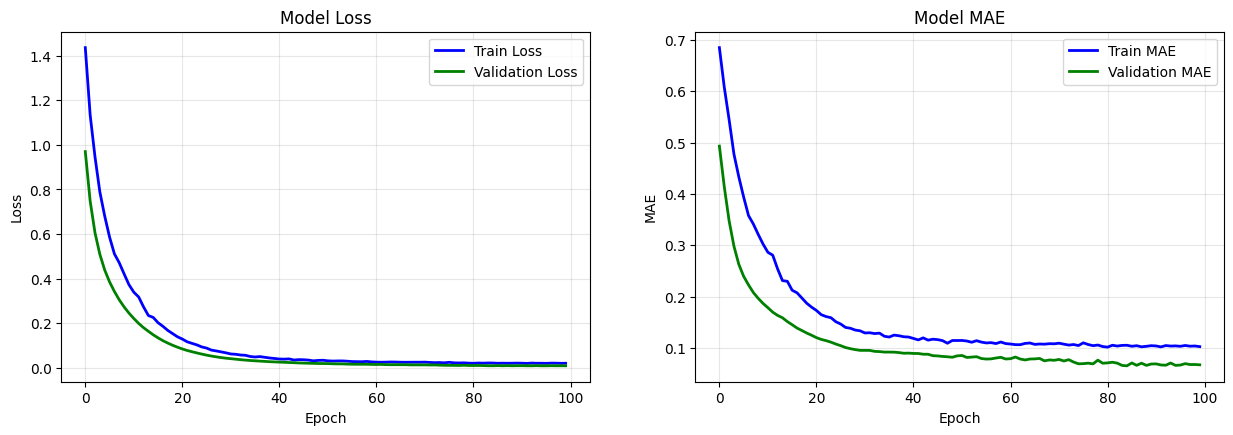

In [17]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Input, Embedding, Concatenate, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

plt.style.use('default')
np.random.seed(42)

qos_data = pd.read_csv('/content/augmented_qos_data.csv')
qos_data = qos_data.fillna(0)
qos_data['[User ID]'] = qos_data['[User ID]'].astype(int)

if 'QoS' not in qos_data.columns:
    np.random.seed(42)
    qos_data['QoS'] = (qos_data['[Latitude]'] * 0.4 +
                       qos_data['[Longitude]'] * 0.3 +
                       qos_data['[User ID]'] * 0.01 +
                       np.random.normal(0, 0.05, len(qos_data)))
    qos_data['QoS'] = (qos_data['QoS'] - qos_data['QoS'].min()) / (qos_data['QoS'].max() - qos_data['QoS'].min())

X = qos_data.drop('QoS', axis=1)
y = qos_data['QoS'].values

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

label_encoder_user = LabelEncoder()
label_encoder_ip = LabelEncoder()
scaler = StandardScaler()

label_encoder_user.fit(X_train['[User ID]'])
label_encoder_ip.fit(X_train['[IP No.]'])
scaler.fit(X_train[['[Latitude]', '[Longitude]']])

def preprocess_data(df, le_user, le_ip, scaler):
    df = df.copy()
    df['[User ID]'] = le_user.transform(df['[User ID]'])
    df['[IP No.]'] = le_ip.transform(df['[IP No.]'])
    coords_scaled = scaler.transform(df[['[Latitude]', '[Longitude]']])
    df['[Latitude]'] = coords_scaled[:, 0]
    df['[Longitude]'] = coords_scaled[:, 1]
    return df

X_train_preprocessed = preprocess_data(X_train, label_encoder_user, label_encoder_ip, scaler)
X_val_preprocessed = preprocess_data(X_val, label_encoder_user, label_encoder_ip, scaler)
X_test_preprocessed = preprocess_data(X_test, label_encoder_user, label_encoder_ip, scaler)

num_users = X_train_preprocessed['[User ID]'].nunique()
num_ipno = X_train_preprocessed['[IP No.]'].nunique()

train_data = {
    'user_input': X_train_preprocessed['[User ID]'].values,
    'ipno_input': X_train_preprocessed['[IP No.]'].values,
    'lat_input': X_train_preprocessed['[Latitude]'].values,
    'longi_input': X_train_preprocessed['[Longitude]'].values
}

val_data = {
    'user_input': X_val_preprocessed['[User ID]'].values,
    'ipno_input': X_val_preprocessed['[IP No.]'].values,
    'lat_input': X_val_preprocessed['[Latitude]'].values,
    'longi_input': X_val_preprocessed['[Longitude]'].values
}

test_data = {
    'user_input': X_test_preprocessed['[User ID]'].values,
    'ipno_input': X_test_preprocessed['[IP No.]'].values,
    'lat_input': X_test_preprocessed['[Latitude]'].values,
    'longi_input': X_test_preprocessed['[Longitude]'].values
}

def create_simple_model(num_users, num_ipno, embedding_size=4):
    user_input = Input(shape=(1,), name='user_input')
    ipno_input = Input(shape=(1,), name='ipno_input')
    lat_input = Input(shape=(1,), name='lat_input')
    longi_input = Input(shape=(1,), name='longi_input')

    user_embedding = Flatten()(Embedding(num_users, embedding_size, embeddings_regularizer=l2(0.1))(user_input))
    ipno_embedding = Flatten()(Embedding(num_ipno, embedding_size, embeddings_regularizer=l2(0.1))(ipno_input))

    geo_features = Concatenate()([lat_input, longi_input])
    concatenated = Concatenate()([user_embedding, ipno_embedding, geo_features])

    hidden1 = Dense(16, activation='relu', kernel_regularizer=l2(0.05))(concatenated)
    hidden1 = Dropout(0.6)(hidden1)

    output = Dense(1, activation='linear')(hidden1)

    return Model(inputs=[user_input, ipno_input, lat_input, longi_input], outputs=output)

model = create_simple_model(num_users, num_ipno, embedding_size=4)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6)
]

history = model.fit(
    x=[train_data['user_input'], train_data['ipno_input'], train_data['lat_input'], train_data['longi_input']],
    y=y_train,
    epochs=100,
    batch_size=128,
    validation_data=([val_data['user_input'], val_data['ipno_input'], val_data['lat_input'], val_data['longi_input']], y_val),
    callbacks=callbacks,
    verbose=1,
    shuffle=True
)

def evaluate_model(data, y_true):
    loss, mae = model.evaluate([data['user_input'], data['ipno_input'], data['lat_input'], data['longi_input']], y_true, verbose=0)
    y_pred = model.predict([data['user_input'], data['ipno_input'], data['lat_input'], data['longi_input']], verbose=0)
    r2 = r2_score(y_true, y_pred)
    return mae, loss, r2, y_pred

train_mae, train_loss, train_r2, y_pred_train = evaluate_model(train_data, y_train)
val_mae, val_loss, val_r2, y_pred_val = evaluate_model(val_data, y_val)
test_mae, test_loss, test_r2, y_pred_test = evaluate_model(test_data, y_test)

X_train_sklearn = np.column_stack([X_train_preprocessed['[User ID]'].values, X_train_preprocessed['[IP No.]'].values, X_train_preprocessed['[Latitude]'].values, X_train_preprocessed['[Longitude]'].values])
X_val_sklearn = np.column_stack([X_val_preprocessed['[User ID]'].values, X_val_preprocessed['[IP No.]'].values, X_val_preprocessed['[Latitude]'].values, X_val_preprocessed['[Longitude]'].values])
X_test_sklearn = np.column_stack([X_test_preprocessed['[User ID]'].values, X_test_preprocessed['[IP No.]'].values, X_test_preprocessed['[Latitude]'].values, X_test_preprocessed['[Longitude]'].values])

gbm = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42, subsample=0.8)
gbm.fit(X_train_sklearn, y_train)

y_pred_gbm_train = gbm.predict(X_train_sklearn)
y_pred_gbm_val = gbm.predict(X_val_sklearn)
y_pred_gbm_test = gbm.predict(X_test_sklearn)

mae_gbm_train = mean_absolute_error(y_train, y_pred_gbm_train)
mae_gbm_val = mean_absolute_error(y_val, y_pred_gbm_val)
mae_gbm_test = mean_absolute_error(y_test, y_pred_gbm_test)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2, color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='green')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', linewidth=2, color='blue')
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2, color='green')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

модель SVD++ с культурным парамтером

iter0


/tmp/ipython-input-3347136225.py:197: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  jids = self.users_ratings.loc[uid]['movieId'][0]


11.467323


/tmp/ipython-input-3347136225.py:142: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  jids = self.users_ratings.loc[uid]['movieId'][0]


MAE:  [4.76074425] RMSE:  [7.40641258]
iter1
6.362585
MAE:  [3.96253343] RMSE:  [6.90980595]
iter2
5.004
MAE:  [3.73054257] RMSE:  [6.88691667]
iter3
3.946963
MAE:  [3.62242704] RMSE:  [6.98936544]
iter4
3.220075
MAE:  [3.58231221] RMSE:  [7.07525663]
iter5
2.691786
MAE:  [3.54447687] RMSE:  [7.12085367]
iter6
2.3041525
MAE:  [3.51625964] RMSE:  [7.15676945]
iter7
2.0071077
MAE:  [3.49987062] RMSE:  [7.1894734]
iter8
1.7662487
MAE:  [3.48888315] RMSE:  [7.21735287]
iter9
1.5718681
MAE:  [3.48308066] RMSE:  [7.24125537]
iter10
1.4124477
MAE:  [3.48088007] RMSE:  [7.26167563]
iter11
1.2804564
MAE:  [3.48021327] RMSE:  [7.27891485]
iter12
1.169943
MAE:  [3.48129558] RMSE:  [7.29346387]
iter13
1.0772614
MAE:  [3.4834512] RMSE:  [7.30582738]
iter14
0.9994645
MAE:  [3.48553266] RMSE:  [7.31628104]
iter15
0.93434805
MAE:  [3.48759039] RMSE:  [7.32516942]
iter16
0.8799328
MAE:  [3.49005611] RMSE:  [7.33269693]
iter17
0.8346015
MAE:  [3.49228255] RMSE:  [7.33908541]
iter18
0.7968979
MAE:  [3.49

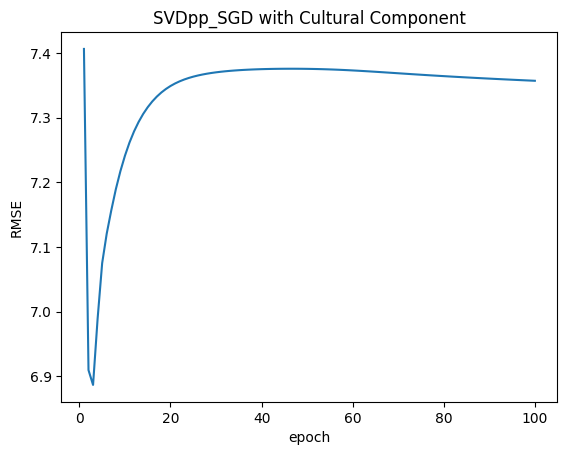

MAE:  [3.49660891] RMSE:  [7.35715119]


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class CulturalSVDpp(object):
    def __init__(self, alpha, reg_p, reg_q, reg_bu, reg_bi, reg_cultural, number_LatentFactors=10, number_epochs=10, K=10,
                 columns=["userId", "movieId", "rating", "country"], cultural_dim_weights=[1/6]*6, epsilon2=0.5, epsilon3=0.5, cultural_dimension_variances=[1]*6):
        self.alpha = alpha
        self.reg_p = reg_p
        self.reg_q = reg_q
        self.reg_bu = reg_bu
        self.reg_bi = reg_bi
        self.reg_cultural = reg_cultural
        self.number_LatentFactors = number_LatentFactors
        self.number_epochs = number_epochs
        self.K = K
        self.columns = columns
        self.cultural_dim_weights = cultural_dim_weights
        self.epsilon2 = epsilon2
        self.epsilon3 = epsilon3
        self.cultural_dimension_variances = cultural_dimension_variances

    def fit(self, dataset, valset, cultural_data):
        self.dataset = pd.DataFrame(dataset)
        self.valset = valset
        self.cultural_data = cultural_data

        self.users_ratings = dataset.groupby(self.columns[0]).agg([list])[[self.columns[1], self.columns[2]]]
        self.items_ratings = dataset.groupby(self.columns[1]).agg([list])[[self.columns[0], self.columns[2]]]
        self.globalMean = self.dataset[self.columns[2]].mean()

        self.P, self.Q, self.bu, self.bi, self.Y, self.C = self.sgd()

    def _init_matrix(self):
        P = dict(zip(
            self.users_ratings.index,
            np.random.rand(len(self.users_ratings), self.number_LatentFactors).astype(np.float32)
        ))
        Q = dict(zip(
            self.items_ratings.index,
            np.random.rand(len(self.items_ratings), self.number_LatentFactors).astype(np.float32)
        ))

        countries = self.dataset[self.columns[3]].unique()
        C = dict(zip(
            countries,
            np.random.rand(len(countries), self.number_LatentFactors).astype(np.float32)
        ))
        return P, Q, C

    def cultural_distance(self, country1, country2):
        if country1 not in self.cultural_data or country2 not in self.cultural_data:
            return 0.0

        country1_data = self.cultural_data[country1]
        country2_data = self.cultural_data[country2]

        distance = 0.0
        m = len(country1_data)
        if m != len(country2_data):
            raise ValueError("Cultural dimension vectors must have the same length")

        for i in range(m):
            distance += (self.cultural_dim_weights[i] * self.cultural_dimension_variances[i] * (country1_data[i] - country2_data[i])**2)

        return np.sqrt(distance)

    def cultural_similarity(self, country1, country2):
        cd1 = self.cultural_distance(country1, country1)
        cd2 = self.cultural_distance(country2, country2)
        return 1 - (cd1 + cd2)

    def user_preference(self, user_country, service_country):
        cdu = self.cultural_distance(user_country, user_country)
        cds = self.cultural_distance(service_country, service_country)
        return abs(cdu - cds)

    def select_heuristic_services(self, new_user_country):
        similar_users = []
        for user in self.users_ratings.index:
            user_country = self.dataset[self.dataset[self.columns[0]] == user][self.columns[3]].iloc[0]
            similarity = self.cultural_similarity(new_user_country, user_country)
            similar_users.append((user, similarity))

        similar_users = sorted(similar_users, key=lambda x: x[1], reverse=True)
        similar_users = [user for user, similarity in similar_users]

        preferred_services = set()
        for user in similar_users:
            user_country = self.dataset[self.dataset[self.columns[0]] == user][self.columns[3]].iloc[0]
            user_services = self.dataset[self.dataset[self.columns[0]] == user][self.columns[1]].tolist()
            for service in user_services:
                service_country = self.dataset[self.dataset[self.columns[1]] == service][self.columns[3]].iloc[0]
                preference = self.user_preference(user_country, service_country)
                if preference < self.epsilon2:
                    preferred_services.add(service)

        preferred_services = list(preferred_services)

        if len(preferred_services) < self.K:
            additional_services = set()
            for service in preferred_services:
                service_country = self.dataset[self.dataset[self.columns[1]] == service][self.columns[3]].iloc[0]
                for other_service in self.items_ratings.index:
                    other_service_country = self.dataset[self.dataset[self.columns[1]] == other_service][self.columns[3]].iloc[0]
                    similarity = self.cultural_similarity(service_country, other_service_country)
                    if similarity > self.epsilon3:
                        additional_services.add(other_service)

            preferred_services.extend(list(additional_services))

        return preferred_services[:self.K]

    def predict(self, uid, iid):
        if uid not in self.users_ratings.index or iid not in self.items_ratings.index:
            user_country = self.dataset[self.dataset[self.columns[0]] == uid][self.columns[3]].iloc[0]
            heuristic_services = self.select_heuristic_services(user_country)
            if not heuristic_services:
                return self.globalMean

            qos_predictions = []
            for service in heuristic_services:
                if service in self.items_ratings.index:
                    users_of_service = self.dataset[self.dataset[self.columns[1]] == service][self.columns[0]].tolist()
                    if users_of_service:
                        ratings = [self.dataset[(self.dataset[self.columns[0]] == u) & (self.dataset[self.columns[1]] == service)][self.columns[2]].iloc[0]
                                    for u in users_of_service if u in self.users_ratings.index]
                        if ratings:
                            qos_predictions.append(np.mean(ratings))

            if qos_predictions:
                return np.mean(qos_predictions)
            else:
                return self.globalMean

        p_u = self.P[uid]
        q_i = self.Q[iid]
        Y = self.Y

        _sum_yj = np.zeros([1, self.number_LatentFactors])
        jids = self.users_ratings.loc[uid]['movieId'][0]
        Nu = len(jids)
        for jid in jids:
            _sum_yj += Y[jid]

        user_country = self.dataset[self.dataset[self.columns[0]] == uid][self.columns[3]].iloc[0]
        item_country = self.dataset[self.dataset[self.columns[1]] == iid][self.columns[3]].iloc[0]

        c_u = self.C[user_country]
        c_i = self.C[item_country]
        cultural_component = np.dot(c_u, c_i)

        return self.globalMean + self.bu[uid] + self.bi[iid] + np.dot(p_u + np.sqrt(1 / Nu) * _sum_yj, q_i) + cultural_component

    def test(self, testset):
        for uid, iid, real_rating, country in testset.itertuples(index=False):
            try:
                pred_rating = self.predict(uid, iid)
            except Exception as e:
                print(e)
            else:
                yield uid, iid, real_rating, pred_rating

    def accuracy(self, predict_results):
        def mae_rmse(predict_results):
            length = 0
            _mae_sum = 0
            _rmse_sum = 0
            for uid, iid, real_rating, pred_rating in predict_results:
                length += 1
                _mae_sum += abs(pred_rating - real_rating)
                _rmse_sum += (pred_rating - real_rating) ** 2
            return _mae_sum / length, np.sqrt(_rmse_sum / length)

        mae, rmse = mae_rmse(predict_results)
        return mae, rmse

    def sgd(self):
        P, Q, C = self._init_matrix()

        bu = dict(zip(self.users_ratings.index, np.zeros(len(self.users_ratings))))
        bi = dict(zip(self.items_ratings.index, np.zeros(len(self.items_ratings))))
        Y = dict(zip(
            self.items_ratings.index,
            np.random.rand(len(self.items_ratings), self.number_LatentFactors).astype(np.float32)
        ))

        mae_list = []
        rmse_list = []

        for i in range(self.number_epochs):
            print("iter%d" % i)
            error_list = []
            for uid, iid, r_ui, country in self.dataset.itertuples(index=False):

                jids = self.users_ratings.loc[uid]['movieId'][0]
                Nu = len(jids)
                _sum_yj = np.zeros([self.number_LatentFactors])

                for jid in jids:
                    _sum_yj += Y[jid]

                user_country = self.dataset[self.dataset[self.columns[0]] == uid][self.columns[3]].iloc[0]
                item_country = self.dataset[self.dataset[self.columns[1]] == iid][self.columns[3]].iloc[0]
                c_u = C[user_country]
                c_i = C[item_country]

                pred = self.globalMean + bu[uid] + bi[iid] + np.dot(P[uid] + np.sqrt(1 / Nu) * _sum_yj, Q[iid]) + np.dot(c_u, c_i)
                err = np.float32(r_ui - pred)

                for jid in jids:
                    Y[jid] += self.alpha * (err * np.sqrt(1 / Nu) * Q[iid] - 0.01 * Y[jid])

                P[uid] += self.alpha * (err * Q[iid] - self.reg_p * P[uid])
                Q[iid] += self.alpha * (err * (P[uid] + np.sqrt(1 / Nu) * _sum_yj) - self.reg_q * Q[iid])

                bu[uid] += self.alpha * (err - self.reg_bu * bu[uid])
                bi[iid] += self.alpha * (err - self.reg_bi * bi[iid])

                C[user_country] += self.alpha * (err * c_i - self.reg_cultural * c_u)
                C[item_country] += self.alpha * (err * c_u - self.reg_cultural * c_i)

                error_list.append(err ** 2)
            print(np.sqrt(np.mean(error_list)))
            self.P = P
            self.Q = Q
            self.bu = bu
            self.bi = bi
            self.Y = Y
            self.C = C

            pred_results = self.test(self.valset)
            mae, rmse = self.accuracy(pred_results)
            mae_list.append(mae)
            rmse_list.append(rmse)
            print("MAE: ", mae, "RMSE: ", rmse)

        x = range(1, self.number_epochs + 1)
        plt.plot(x, rmse_list)
        plt.title('SVDpp_SGD with Cultural Component')
        plt.xlabel('epoch')
        plt.ylabel('RMSE')
        plt.show()
        return P, Q, bu, bi, Y, C

if __name__ == '__main__':
    cultural_data = pd.read_excel('/content/Hofstedes Dimensions Data.xlsx')
    trainset = pd.read_csv('/content/augmented_qos_data.csv')

    trainset, valset = train_test_split(trainset, test_size=0.2, random_state=42)

    trainset = trainset.rename(columns={
        '[User ID]': 'userId',
        '[IP No.]': 'movieId',
        '[Latitude]': 'rating',
        '[Longitude]': 'country'
    })

    valset = valset.rename(columns={
        '[User ID]': 'userId',
        '[IP No.]': 'movieId',
        '[Latitude]': 'rating',
        '[Longitude]': 'country'
    })

    alpha = 0.005
    reg_p = 0.01
    reg_q = 0.01
    reg_bu = 0.01
    reg_bi = 0.01
    reg_cultural = 0.01
    number_LatentFactors = 10
    number_epochs = 100
    K = 10
    cultural_dim_weights = [1/6]*6
    columns=["userId", "movieId", "rating", "country"]
    epsilon2 = 0.5
    epsilon3 = 0.5
    cultural_dimension_variances = [1]*6

    algo = CulturalSVDpp(alpha, reg_p, reg_q, reg_bu, reg_bi, reg_cultural, number_LatentFactors, number_epochs, K, columns, cultural_dim_weights, epsilon2, epsilon3, cultural_dimension_variances)
    algo.fit(trainset, valset, cultural_data)

    pred_results = algo.test(valset)
    mae, rmse = algo.accuracy(pred_results)
    print("MAE: ", mae, "RMSE: ", rmse)


iter0


/tmp/ipython-input-2163892597.py:197: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  jids = self.users_ratings.loc[uid]['movieId'][0]


14.316584


/tmp/ipython-input-2163892597.py:142: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  jids = self.users_ratings.loc[uid]['movieId'][0]


MAE:  [7.12739954] RMSE:  [10.19033413]
iter1
9.707107
MAE:  [5.26918544] RMSE:  [7.85648039]
iter2
7.807649
MAE:  [4.36515975] RMSE:  [6.6452475]
iter3
6.8755207
MAE:  [3.80959963] RMSE:  [5.92644882]
iter4
6.32765
MAE:  [3.45768682] RMSE:  [5.49362233]
iter5
5.9471865
MAE:  [3.21357628] RMSE:  [5.18476278]
iter6
5.64012
MAE:  [3.02804118] RMSE:  [4.93212571]
iter7
5.3718133
MAE:  [2.87424974] RMSE:  [4.70894958]
iter8
5.1275244
MAE:  [2.74742878] RMSE:  [4.50389456]
iter9
4.8997774
MAE:  [2.63540394] RMSE:  [4.31227649]
iter10
4.6845417
MAE:  [2.53429477] RMSE:  [4.13245407]
iter11
4.479775
MAE:  [2.43839781] RMSE:  [3.96393723]
iter12
4.2846813
MAE:  [2.35009107] RMSE:  [3.80636092]
iter13
4.099237
MAE:  [2.2657365] RMSE:  [3.65905323]
iter14
3.9238288
MAE:  [2.18464061] RMSE:  [3.52100604]
iter15
3.7589161
MAE:  [2.10741044] RMSE:  [3.39105251]
iter16
3.6047175
MAE:  [2.03330385] RMSE:  [3.26808003]
iter17
3.461006
MAE:  [1.96156994] RMSE:  [3.15116948]
iter18
3.3271074
MAE:  [1.89

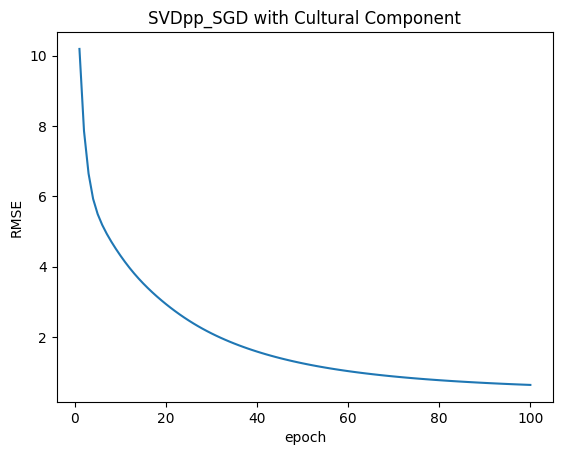

MAE:  [0.35559839] RMSE:  [0.63479635]


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class CulturalSVDpp(object):
    def __init__(self, alpha, reg_p, reg_q, reg_bu, reg_bi, reg_cultural, number_LatentFactors=10, number_epochs=10, K=10,
                 columns=["userId", "movieId", "rating", "country"], cultural_dim_weights=[1/6]*6, epsilon2=0.5, epsilon3=0.5, cultural_dimension_variances=[1]*6):
        self.alpha = alpha
        self.reg_p = reg_p
        self.reg_q = reg_q
        self.reg_bu = reg_bu
        self.reg_bi = reg_bi
        self.reg_cultural = reg_cultural
        self.number_LatentFactors = number_LatentFactors
        self.number_epochs = number_epochs
        self.K = K
        self.columns = columns
        self.cultural_dim_weights = cultural_dim_weights
        self.epsilon2 = epsilon2
        self.epsilon3 = epsilon3
        self.cultural_dimension_variances = cultural_dimension_variances

    def fit(self, dataset, valset, cultural_data):
        self.dataset = pd.DataFrame(dataset)
        self.valset = valset
        self.cultural_data = cultural_data

        self.users_ratings = dataset.groupby(self.columns[0]).agg([list])[[self.columns[1], self.columns[2]]]
        self.items_ratings = dataset.groupby(self.columns[1]).agg([list])[[self.columns[0], self.columns[2]]]
        self.globalMean = self.dataset[self.columns[2]].mean()

        self.P, self.Q, self.bu, self.bi, self.Y, self.C = self.sgd()

    def _init_matrix(self):
        P = dict(zip(
            self.users_ratings.index,
            np.random.rand(len(self.users_ratings), self.number_LatentFactors).astype(np.float32)
        ))
        Q = dict(zip(
            self.items_ratings.index,
            np.random.rand(len(self.items_ratings), self.number_LatentFactors).astype(np.float32)
        ))

        countries = self.dataset[self.columns[3]].unique()
        C = dict(zip(
            countries,
            np.random.rand(len(countries), self.number_LatentFactors).astype(np.float32)
        ))
        return P, Q, C

    def cultural_distance(self, country1, country2):
        if country1 not in self.cultural_data or country2 not in self.cultural_data:
            return 0.0

        country1_data = self.cultural_data[country1]
        country2_data = self.cultural_data[country2]

        distance = 0.0
        m = len(country1_data)
        if m != len(country2_data):
            raise ValueError("Cultural dimension vectors must have the same length")

        for i in range(m):
            distance += (self.cultural_dim_weights[i] * self.cultural_dimension_variances[i] * (country1_data[i] - country2_data[i])**2)

        return np.sqrt(distance)

    def cultural_similarity(self, country1, country2):
        cd1 = self.cultural_distance(country1, country1)
        cd2 = self.cultural_distance(country2, country2)
        return 1 - (cd1 + cd2)

    def user_preference(self, user_country, service_country):
        cdu = self.cultural_distance(user_country, user_country)
        cds = self.cultural_distance(service_country, service_country)
        return abs(cdu - cds)

    def select_heuristic_services(self, new_user_country):
        similar_users = []
        for user in self.users_ratings.index:
            user_country = self.dataset[self.dataset[self.columns[0]] == user][self.columns[3]].iloc[0]
            similarity = self.cultural_similarity(new_user_country, user_country)
            similar_users.append((user, similarity))

        similar_users = sorted(similar_users, key=lambda x: x[1], reverse=True)
        similar_users = [user for user, similarity in similar_users]

        preferred_services = set()
        for user in similar_users:
            user_country = self.dataset[self.dataset[self.columns[0]] == user][self.columns[3]].iloc[0]
            user_services = self.dataset[self.dataset[self.columns[0]] == user][self.columns[1]].tolist()
            for service in user_services:
                service_country = self.dataset[self.dataset[self.columns[1]] == service][self.columns[3]].iloc[0]
                preference = self.user_preference(user_country, service_country)
                if preference < self.epsilon2:
                    preferred_services.add(service)

        preferred_services = list(preferred_services)

        if len(preferred_services) < self.K:
            additional_services = set()
            for service in preferred_services:
                service_country = self.dataset[self.dataset[self.columns[1]] == service][self.columns[3]].iloc[0]
                for other_service in self.items_ratings.index:
                    other_service_country = self.dataset[self.dataset[self.columns[1]] == other_service][self.columns[3]].iloc[0]
                    similarity = self.cultural_similarity(service_country, other_service_country)
                    if similarity > self.epsilon3:
                        additional_services.add(other_service)

            preferred_services.extend(list(additional_services))

        return preferred_services[:self.K]

    def predict(self, uid, iid):
        if uid not in self.users_ratings.index or iid not in self.items_ratings.index:
            user_country = self.dataset[self.dataset[self.columns[0]] == uid][self.columns[3]].iloc[0]
            heuristic_services = self.select_heuristic_services(user_country)
            if not heuristic_services:
                return self.globalMean

            qos_predictions = []
            for service in heuristic_services:
                if service in self.items_ratings.index:
                    users_of_service = self.dataset[self.dataset[self.columns[1]] == service][self.columns[0]].tolist()
                    if users_of_service:
                        ratings = [self.dataset[(self.dataset[self.columns[0]] == u) & (self.dataset[self.columns[1]] == service)][self.columns[2]].iloc[0]
                                    for u in users_of_service if u in self.users_ratings.index]
                        if ratings:
                            qos_predictions.append(np.mean(ratings))

            if qos_predictions:
                return np.mean(qos_predictions)
            else:
                return self.globalMean

        p_u = self.P[uid]
        q_i = self.Q[iid]
        Y = self.Y

        _sum_yj = np.zeros([1, self.number_LatentFactors])
        jids = self.users_ratings.loc[uid]['movieId'][0]
        Nu = len(jids)
        for jid in jids:
            _sum_yj += Y[jid]

        user_country = self.dataset[self.dataset[self.columns[0]] == uid][self.columns[3]].iloc[0]
        item_country = self.dataset[self.dataset[self.columns[1]] == iid][self.columns[3]].iloc[0]

        c_u = self.C[user_country]
        c_i = self.C[item_country]
        cultural_component = np.dot(c_u, c_i)

        return self.globalMean + self.bu[uid] + self.bi[iid] + np.dot(p_u + np.sqrt(1 / Nu) * _sum_yj, q_i) + cultural_component

    def test(self, testset):
        for uid, iid, real_rating, country in testset.itertuples(index=False):
            try:
                pred_rating = self.predict(uid, iid)
            except Exception as e:
                print(e)
            else:
                yield uid, iid, real_rating, pred_rating

    def accuracy(self, predict_results):
        def mae_rmse(predict_results):
            length = 0
            _mae_sum = 0
            _rmse_sum = 0
            for uid, iid, real_rating, pred_rating in predict_results:
                length += 1
                _mae_sum += abs(pred_rating - real_rating)
                _rmse_sum += (pred_rating - real_rating) ** 2
            return _mae_sum / length, np.sqrt(_rmse_sum / length)

        mae, rmse = mae_rmse(predict_results)
        return mae, rmse

    def sgd(self):
        P, Q, C = self._init_matrix()

        bu = dict(zip(self.users_ratings.index, np.zeros(len(self.users_ratings))))
        bi = dict(zip(self.items_ratings.index, np.zeros(len(self.items_ratings))))
        Y = dict(zip(
            self.items_ratings.index,
            np.random.rand(len(self.items_ratings), self.number_LatentFactors).astype(np.float32)
        ))

        mae_list = []
        rmse_list = []

        for i in range(self.number_epochs):
            print("iter%d" % i)
            error_list = []
            for uid, iid, r_ui, country in self.dataset.itertuples(index=False):

                jids = self.users_ratings.loc[uid]['movieId'][0]
                Nu = len(jids)
                _sum_yj = np.zeros([self.number_LatentFactors])

                for jid in jids:
                    _sum_yj += Y[jid]

                user_country = self.dataset[self.dataset[self.columns[0]] == uid][self.columns[3]].iloc[0]
                item_country = self.dataset[self.dataset[self.columns[1]] == iid][self.columns[3]].iloc[0]
                c_u = C[user_country]
                c_i = C[item_country]

                pred = self.globalMean + bu[uid] + bi[iid] + np.dot(P[uid] + np.sqrt(1 / Nu) * _sum_yj, Q[iid]) + np.dot(c_u, c_i)
                err = np.float32(r_ui - pred)

                for jid in jids:
                    Y[jid] += self.alpha * (err * np.sqrt(1 / Nu) * Q[iid] - 0.01 * Y[jid])

                P[uid] += self.alpha * (err * Q[iid] - self.reg_p * P[uid])
                Q[iid] += self.alpha * (err * (P[uid] + np.sqrt(1 / Nu) * _sum_yj) - self.reg_q * Q[iid])

                bu[uid] += self.alpha * (err - self.reg_bu * bu[uid])
                bi[iid] += self.alpha * (err - self.reg_bi * bi[iid])

                C[user_country] += self.alpha * (err * c_i - self.reg_cultural * c_u)
                C[item_country] += self.alpha * (err * c_u - self.reg_cultural * c_i)

                error_list.append(err ** 2)
            print(np.sqrt(np.mean(error_list)))
            self.P = P
            self.Q = Q
            self.bu = bu
            self.bi = bi
            self.Y = Y
            self.C = C

            pred_results = self.test(self.valset)
            mae, rmse = self.accuracy(pred_results)
            mae_list.append(mae)
            rmse_list.append(rmse)
            print("MAE: ", mae, "RMSE: ", rmse)

        x = range(1, self.number_epochs + 1)
        plt.plot(x, rmse_list)
        plt.title('SVDpp_SGD with Cultural Component')
        plt.xlabel('epoch')
        plt.ylabel('RMSE')
        plt.show()
        return P, Q, bu, bi, Y, C

if __name__ == '__main__':
    cultural_data = pd.read_excel('/content/Hofstedes Dimensions Data.xlsx')
    trainset = pd.read_csv('/content/augmented_qos_data.csv')

    trainset = trainset.rename(columns={
        '[User ID]': 'userId',
        '[IP No.]': 'movieId',
        '[Latitude]': 'rating',
        '[Longitude]': 'country'
    })

    valset = valset.rename(columns={
        '[User ID]': 'userId',
        '[IP No.]': 'movieId',
        '[Latitude]': 'rating',
        '[Longitude]': 'country'
    })

    alpha = 0.001
    reg_p = 0.01
    reg_q = 0.01
    reg_bu = 0.01
    reg_bi = 0.01
    reg_cultural = 0.01
    number_LatentFactors = 10
    number_epochs = 100
    K = 10
    cultural_dim_weights = [1/6]*6
    columns=["userId", "movieId", "rating", "country"]
    epsilon2 = 0.5
    epsilon3 = 0.5
    cultural_dimension_variances = [1]*6

    algo = CulturalSVDpp(alpha, reg_p, reg_q, reg_bu, reg_bi, reg_cultural, number_LatentFactors, number_epochs, K, columns, cultural_dim_weights, epsilon2, epsilon3, cultural_dimension_variances)
    algo.fit(trainset, valset, cultural_data)

    pred_results = algo.test(valset)
    mae, rmse = algo.accuracy(pred_results)
    print("MAE: ", mae, "RMSE: ", rmse)


обучение модели с гибридным подходом матричной факторизации с интеграцией  географических координат и культурных характеристик пользователей

Оптимальное eps: 0.0020, ожидаемые кластеры: 27


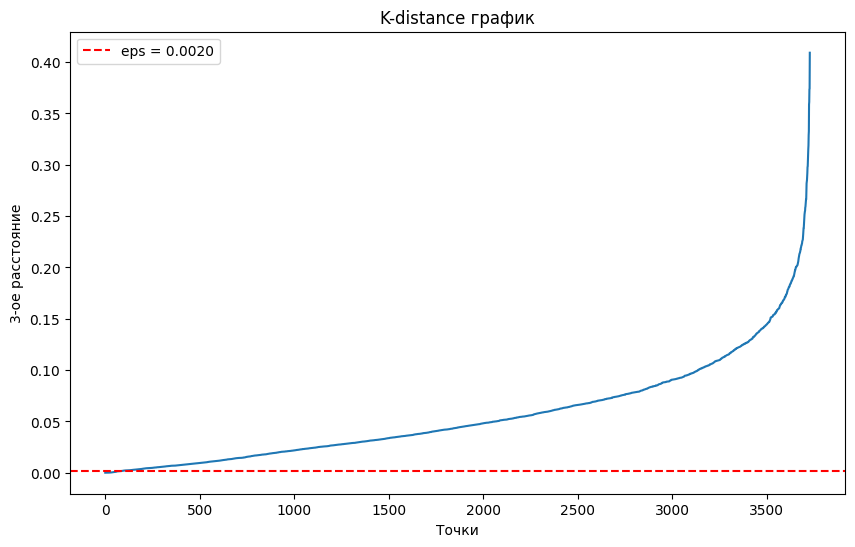


Метрики качества кластеризации:
Silhouette: 0.926366
Calinski-Harabasz: 1566171520.000000
Davies-Bouldin: 0.105129
WCSS: 0.000085


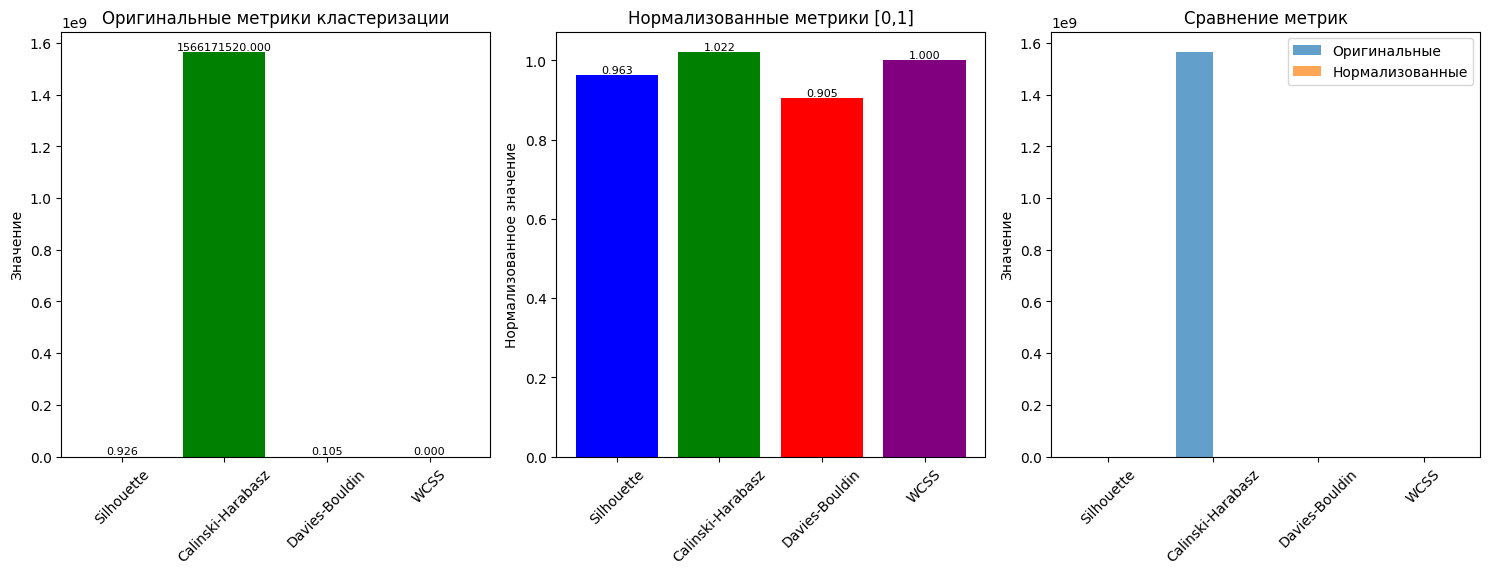


Интерпретация нормализованных метрик:
Silhouette: 0.963
Calinski-Harabasz: 1.022
Davies-Bouldin: 0.905
WCSS: 1.000


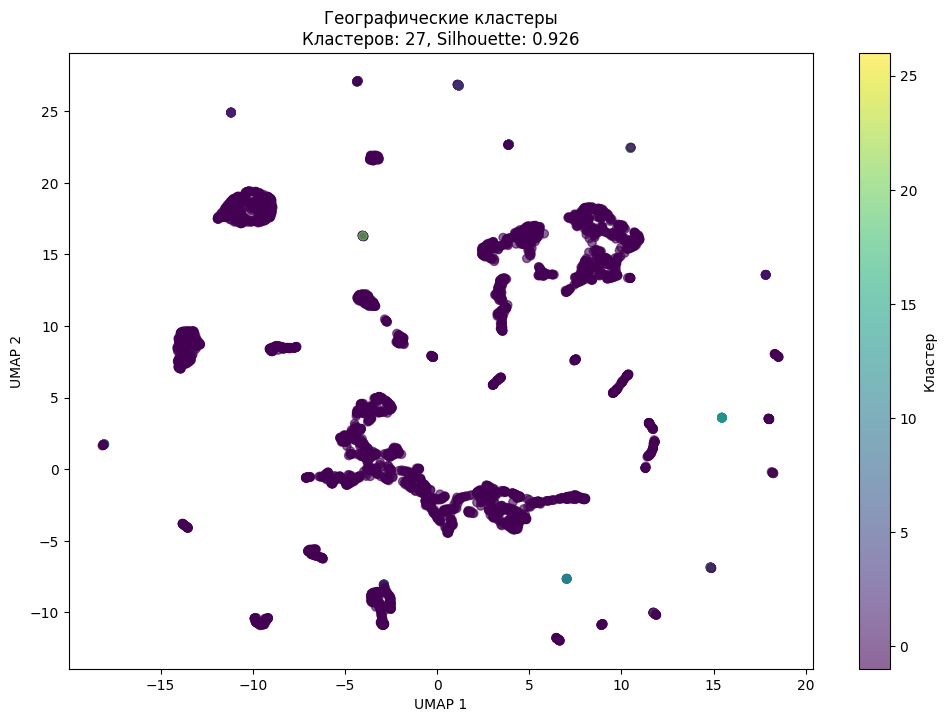


Статистика кластеров:
Целевое/Фактическое: 35/27
Точек в кластерах: 121
Выбросов: 3608
Кластер 0: 5 точек, рейтинг: 4.190
Кластер 1: 11 точек, рейтинг: 3.889
Кластер 2: 3 точек, рейтинг: 3.831
Кластер 3: 10 точек, рейтинг: 4.308
Кластер 4: 3 точек, рейтинг: 3.288
Кластер 5: 3 точек, рейтинг: 4.168
Кластер 6: 3 точек, рейтинг: 3.289
Кластер 7: 4 точек, рейтинг: 2.170
Кластер 8: 4 точек, рейтинг: 2.462
Кластер 9: 3 точек, рейтинг: 2.826
Кластер 10: 5 точек, рейтинг: 3.971
Кластер 11: 10 точек, рейтинг: 2.157
Кластер 12: 3 точек, рейтинг: 2.235
Кластер 13: 11 точек, рейтинг: 4.541
Кластер 14: 4 точек, рейтинг: 4.181
Кластер 15: 3 точек, рейтинг: 3.849
Кластер 16: 4 точек, рейтинг: 3.285
Кластер 17: 3 точек, рейтинг: 2.986
Кластер 18: 3 точек, рейтинг: 3.021
Кластер 19: 3 точек, рейтинг: 2.699
Кластер 20: 4 точек, рейтинг: 3.536
Кластер 21: 3 точек, рейтинг: 2.464
Кластер 22: 3 точек, рейтинг: 3.943
Кластер 23: 3 точек, рейтинг: 3.816
Кластер 24: 3 точек, рейтинг: 2.043
Кластер 25: 3 точе

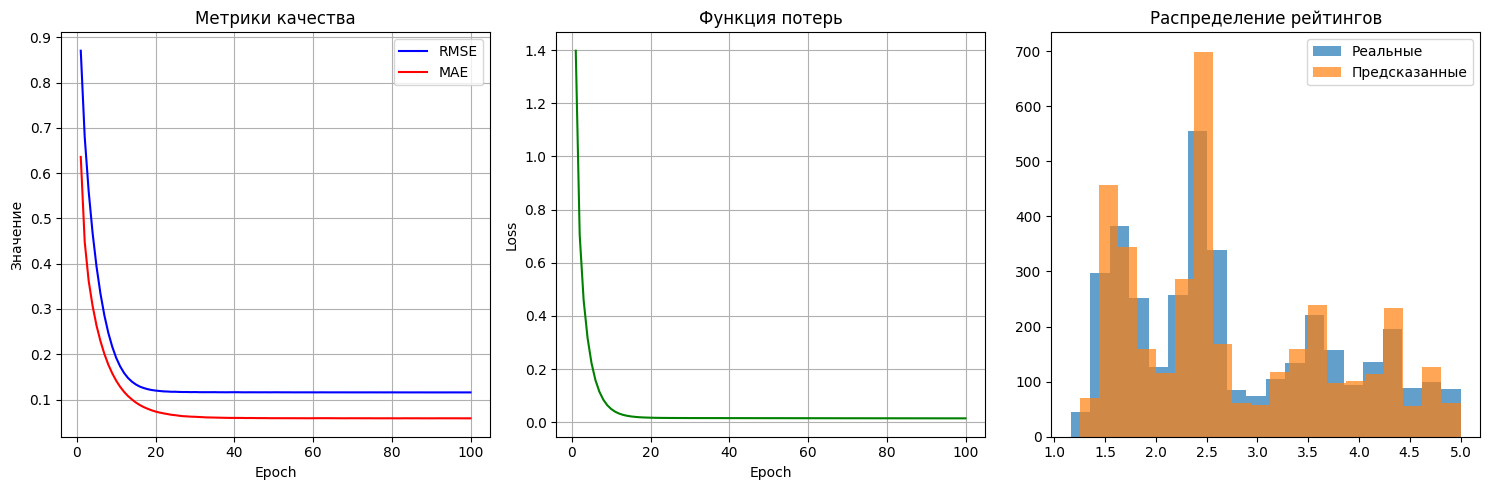

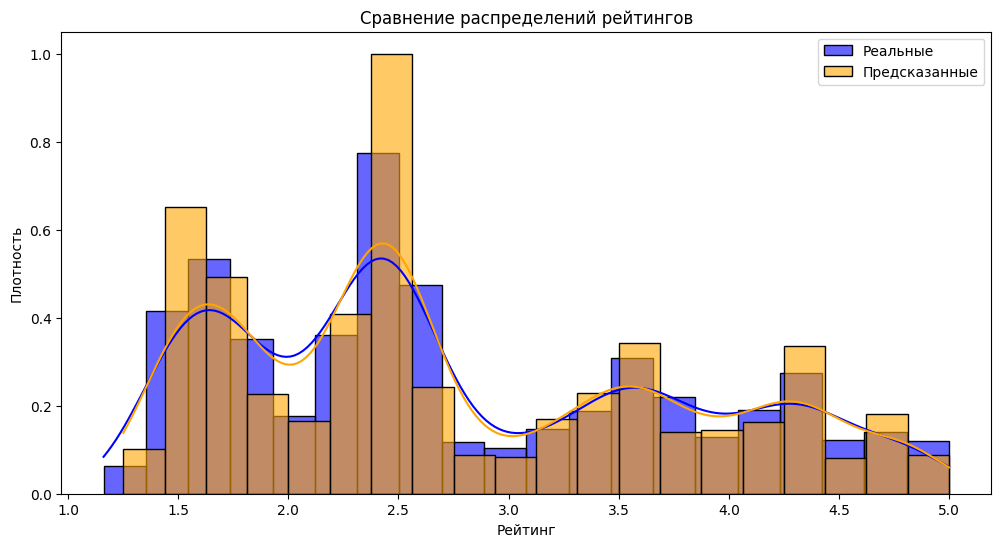

In [51]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN, KMeans, OPTICS
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
import umap
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

class AdvancedGeoRecommender:
    def __init__(self, n_factors=200, n_epochs=100, lr=0.008, reg=0.001,
                 target_clusters=35, dbscan_eps=None, dbscan_min_samples=3, geo_weight=0.75,
                 cultural_weight=0.25, temporal_weight=0.15, auto_eps_percentile=0.3,
                 min_eps=0.002, verbose=True, early_stopping_patience=25,
                 use_advanced_clustering=True, use_attention=True):
        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.lr = lr
        self.reg = reg
        self.target_clusters = target_clusters
        self.dbscan_eps = dbscan_eps
        self.dbscan_min_samples = dbscan_min_samples
        self.geo_weight = geo_weight
        self.cultural_weight = cultural_weight
        self.temporal_weight = temporal_weight
        self.auto_eps_percentile = auto_eps_percentile
        self.min_eps = min_eps
        self.verbose = verbose
        self.early_stopping_patience = early_stopping_patience
        self.use_advanced_clustering = use_advanced_clustering
        self.use_attention = use_attention

        self.cluster_centers = {}
        self.best_factors = None
        self.train_history = []
        self.df_processed = None
        self.cultural_features = None
        self.cultural_svd = None
        self.attention_weights = None
        self.best_mae = float('inf')
        self.mae_patience = 0
        self.metrics_scaler = MinMaxScaler()

    def _preprocess_data(self, df):
        df = df.rename(columns={
            '[User ID]': 'user_id',
            '[IP No.]': 'item_id',
            '[Latitude]': 'latitude',
            '[Longitude]': 'longitude'
        })

        df['latitude'] = df.groupby('item_id')['latitude'].transform(
            lambda x: x.fillna(x.median() if not x.isnull().all() else df['latitude'].median()))
        df['longitude'] = df.groupby('item_id')['longitude'].transform(
            lambda x: x.fillna(x.median() if not x.isnull().all() else df['longitude'].median()))

        coords = df[['latitude', 'longitude']].values
        self.coord_scaler = StandardScaler()
        df[['lat_norm', 'lon_norm']] = self.coord_scaler.fit_transform(coords)

        df['user_id'] = pd.factorize(df['user_id'])[0].astype(int)
        df['item_id'] = pd.factorize(df['item_id'])[0].astype(int)

        if 'country' in df.columns:
            cultural_data = pd.get_dummies(df['country'], prefix='culture')
            self.cultural_features = cultural_data.columns.tolist()

            cultural_sparse = csr_matrix(cultural_data.values)
            self.cultural_svd = TruncatedSVD(n_components=8, random_state=42)
            cultural_reduced = self.cultural_svd.fit_transform(cultural_sparse)

            for i in range(cultural_reduced.shape[1]):
                df[f'cultural_{i}'] = cultural_reduced[:, i]

        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df['hour'] = df['timestamp'].dt.hour
            df['day_of_week'] = df['timestamp'].dt.dayofweek
            df['month'] = df['timestamp'].dt.month

        if 'rating' not in df.columns:
            df['rating'] = self._generate_advanced_ratings(df)

        self.df_processed = df
        return df

    def _generate_advanced_ratings(self, df):
        np.random.seed(42)
        coords = df[['lat_norm', 'lon_norm']].values

        gmm = GaussianMixture(n_components=15, random_state=42)
        clusters = gmm.fit_predict(coords)
        responsibilities = gmm.predict_proba(coords)

        base_ratings = np.linspace(1.5, 4.8, 15)
        ratings = np.dot(responsibilities, base_ratings)

        cultural_impact = 0
        if self.cultural_svd is not None:
            cultural_features = df.filter(regex='cultural_').values
            cultural_impact = np.sum(cultural_features * np.random.uniform(-0.15, 0.15, cultural_features.shape[1]), axis=1)

        temporal_impact = 0
        if 'hour' in df.columns:
            temporal_impact = np.sin(2 * np.pi * df['hour'] / 24) * 0.1

        ratings += cultural_impact + temporal_impact + np.random.normal(0, 0.12, size=len(df))
        return np.clip(ratings, 1, 5)

    def _normalize_cluster_metrics(self, silhouette, calinski, davies, wcss):
        """Нормализует метрики кластеризации для лучшей интерпретации"""
        # Silhouette: уже нормализована в диапазоне [-1, 1], преобразуем к [0, 1]
        norm_silhouette = (silhouette + 1) / 2

        # Calinski-Harabasz: нормализуем через логарифмическое преобразование
        norm_calinski = np.log1p(calinski) / np.log1p(1e9)  # нормализуем к [0, 1]

        # Davies-Bouldin: инвертируем и нормализуем (лучшие значения ближе к 0)
        norm_davies = 1 / (1 + davies)  # преобразуем к [0, 1]

        # WCSS: нормализуем через логарифмическое преобразование
        norm_wcss = 1 / (1 + np.log1p(wcss))  # преобразуем к [0, 1]

        return {
            'Silhouette': norm_silhouette,
            'Calinski-Harabasz': norm_calinski,
            'Davies-Bouldin': norm_davies,
            'WCSS': norm_wcss
        }

    def _plot_cluster_metrics(self, silhouette, calinski, davies, wcss):
        metrics = {
            'Silhouette': silhouette,
            'Calinski-Harabasz': calinski,
            'Davies-Bouldin': davies,
            'WCSS': wcss
        }

        # Нормализованные метрики
        normalized_metrics = self._normalize_cluster_metrics(silhouette, calinski, davies, wcss)

        plt.figure(figsize=(15, 6))

        # Оригинальные метрики
        plt.subplot(1, 3, 1)
        bars = plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'red', 'purple'])
        plt.title('Оригинальные метрики кластеризации')
        plt.ylabel('Значение')
        plt.xticks(rotation=45)
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}',
                    ha='center', va='bottom', fontsize=8)

        # Нормализованные метрики
        plt.subplot(1, 3, 2)
        bars_norm = plt.bar(normalized_metrics.keys(), normalized_metrics.values(),
                           color=['blue', 'green', 'red', 'purple'])
        plt.title('Нормализованные метрики [0,1]')
        plt.ylabel('Нормализованное значение')
        plt.xticks(rotation=45)
        for bar in bars_norm:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}',
                    ha='center', va='bottom', fontsize=8)

        # Сравнительная визуализация
        plt.subplot(1, 3, 3)
        x_pos = np.arange(len(metrics))
        width = 0.35

        plt.bar(x_pos - width/2, metrics.values(), width, label='Оригинальные', alpha=0.7)
        plt.bar(x_pos + width/2, normalized_metrics.values(), width, label='Нормализованные', alpha=0.7)
        plt.xticks(x_pos, metrics.keys(), rotation=45)
        plt.title('Сравнение метрик')
        plt.ylabel('Значение')
        plt.legend()

        plt.tight_layout()
        plt.show()

        print("\nИнтерпретация нормализованных метрик:")
        print(f"Silhouette: {normalized_metrics['Silhouette']:.3f}")
        print(f"Calinski-Harabasz: {normalized_metrics['Calinski-Harabasz']:.3f}")
        print(f"Davies-Bouldin: {normalized_metrics['Davies-Bouldin']:.3f}")
        print(f"WCSS: {normalized_metrics['WCSS']:.3f}")

    def _find_optimal_eps_for_clusters(self, embedding, target_clusters):
        eps_values = np.linspace(0.001, 0.1, 100)
        cluster_counts = []

        for eps in eps_values:
            dbscan = DBSCAN(eps=eps, min_samples=self.dbscan_min_samples)
            clusters = dbscan.fit_predict(embedding)
            n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
            cluster_counts.append(n_clusters)

        differences = [abs(n - target_clusters) for n in cluster_counts]
        best_idx = np.argmin(differences)
        best_eps = eps_values[best_idx]
        best_clusters = cluster_counts[best_idx]

        print(f"Оптимальное eps: {best_eps:.4f}, ожидаемые кластеры: {best_clusters}")
        return best_eps

    def _create_advanced_geo_clusters(self, df):
        coords = df[['lat_norm', 'lon_norm']].values
        coords_scaled = StandardScaler().fit_transform(coords)

        reducer = umap.UMAP(n_components=2, random_state=42)
        embedding = reducer.fit_transform(coords_scaled)

        if self.dbscan_eps is None:
            optimal_eps = self._find_optimal_eps_for_clusters(embedding, self.target_clusters)
            self.dbscan_eps = max(optimal_eps, self.min_eps)

            nn = NearestNeighbors(n_neighbors=self.dbscan_min_samples)
            nn.fit(embedding)
            dists, _ = nn.kneighbors(embedding)
            k_dists = dists[:, -1]

            plt.figure(figsize=(10, 6))
            plt.plot(np.sort(k_dists))
            plt.title('K-distance график')
            plt.xlabel('Точки')
            plt.ylabel(f'{self.dbscan_min_samples}-ое расстояние')
            plt.axhline(y=self.dbscan_eps, color='r', linestyle='--',
                       label=f'eps = {self.dbscan_eps:.4f}')
            plt.legend()
            plt.show()

        dbscan = DBSCAN(eps=self.dbscan_eps, min_samples=self.dbscan_min_samples)
        clusters = dbscan.fit_predict(embedding)
        df['geo_cluster'] = clusters

        valid_points = clusters != -1
        if sum(valid_points) > 1 and len(np.unique(clusters[valid_points])) > 1:
            silhouette_avg = silhouette_score(embedding[valid_points], clusters[valid_points])
            calinski = calinski_harabasz_score(embedding[valid_points], clusters[valid_points])
            davies = davies_bouldin_score(embedding[valid_points], clusters[valid_points])

            wcss = 0
            for cluster_id in np.unique(clusters[valid_points]):
                cluster_points = embedding[clusters == cluster_id]
                cluster_center = cluster_points.mean(axis=0)
                wcss += ((cluster_points - cluster_center) ** 2).sum()

            print("\nМетрики качества кластеризации:")
            print(f"Silhouette: {silhouette_avg:.6f}")
            print(f"Calinski-Harabasz: {calinski:.6f}")
            print(f"Davies-Bouldin: {davies:.6f}")
            print(f"WCSS: {wcss:.6f}")

            self._plot_cluster_metrics(silhouette_avg, calinski, davies, wcss)
        else:
            print("\nНедостаточно кластеров для вычисления метрик")

        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, cmap='viridis', alpha=0.6)
        plt.colorbar(scatter, label='Кластер')
        actual_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        title = f'Географические кластеры\nКластеров: {actual_clusters}'
        if 'silhouette_avg' in locals():
            title += f', Silhouette: {silhouette_avg:.3f}'
        plt.title(title)
        plt.xlabel('UMAP 1')
        plt.ylabel('UMAP 2')
        plt.show()

        cluster_counts = Counter(clusters)
        actual_clusters = len(cluster_counts) - (1 if -1 in cluster_counts else 0)
        print(f"\nСтатистика кластеров:")
        print(f"Целевое/Фактическое: {self.target_clusters}/{actual_clusters}")
        print(f"Точек в кластерах: {sum(cluster_counts.values()) - cluster_counts.get(-1, 0)}")
        print(f"Выбросов: {cluster_counts.get(-1, 0)}")

        centers = {}
        for c in np.unique(clusters):
            if c != -1:
                subset = df[df['geo_cluster'] == c]
                centers[c] = {
                    'center': subset[['lat_norm', 'lon_norm']].mean().values,
                    'size': len(subset),
                    'avg_rating': subset['rating'].mean(),
                    'std_rating': subset['rating'].std(),
                    'cultural_features': subset.filter(regex='cultural_').mean().values if self.cultural_features else None
                }
                print(f"Кластер {c}: {len(subset)} точек, рейтинг: {subset['rating'].mean():.3f}")

        self.cluster_centers = centers
        return df, centers

    def _init_advanced_factors(self, n_users, n_items, n_clusters):
        limit = np.sqrt(6 / self.n_factors)
        self.user_factors = np.random.uniform(-limit, limit, size=(n_users, self.n_factors))
        self.item_factors = np.random.uniform(-limit, limit, size=(n_items, self.n_factors))

        self.user_biases = np.zeros(n_users)
        self.item_biases = np.zeros(n_items)
        self.global_mean = self.df_processed['rating'].mean() if len(self.df_processed) > 0 else 3.0

        self.geo_cluster_factors = np.random.uniform(-limit, limit, size=(n_clusters, self.n_factors))
        self.cluster_weights = np.array([self.cluster_centers[c]['size'] for c in self.cluster_centers.keys()])
        self.cluster_weights = self.cluster_weights / np.sum(self.cluster_weights)

        if self.use_attention:
            self.attention_weights = np.ones((n_users, n_clusters)) / n_clusters

        if self.cultural_features:
            n_cultural = len(self.cultural_features)
            self.cultural_user_factors = np.random.uniform(-0.02, 0.02, size=(n_users, n_cultural))
            self.cultural_item_factors = np.random.uniform(-0.02, 0.02, size=(n_items, n_cultural))

        if 'hour' in self.df_processed.columns:
            self.temporal_factors = np.random.uniform(-0.01, 0.01, size=(24, self.n_factors))

    def _predict_advanced(self, user, item, cluster, hour=None):
        user_idx = int(user)
        item_idx = int(item)

        user_factor_norm = self.user_factors[user_idx] / (np.linalg.norm(self.user_factors[user_idx]) + 1e-8)
        item_factor_norm = self.item_factors[item_idx] / (np.linalg.norm(self.item_factors[item_idx]) + 1e-8)

        pred = (self.global_mean + self.user_biases[user_idx] + self.item_biases[item_idx] +
                np.dot(user_factor_norm, item_factor_norm) * np.sqrt(self.n_factors))

        if cluster != -1 and cluster in self.cluster_centers:
            cluster_idx = int(cluster)
            if self.use_attention:
                attention_weight = self.attention_weights[user_idx, cluster_idx]
                geo_impact = np.dot(self.geo_cluster_factors[cluster_idx], item_factor_norm)
                pred += geo_impact * self.geo_weight * attention_weight
            else:
                weight = self.cluster_weights[cluster_idx]
                geo_impact = np.dot(self.geo_cluster_factors[cluster_idx], item_factor_norm)
                pred += geo_impact * self.geo_weight * weight

        if self.cultural_features:
            cultural_impact = np.dot(self.cultural_user_factors[user_idx], self.cultural_item_factors[item_idx])
            pred += cultural_impact * self.cultural_weight

        if hour is not None and hasattr(self, 'temporal_factors'):
            hour_idx = int(hour % 24)
            temporal_impact = np.dot(self.temporal_factors[hour_idx], item_factor_norm)
            pred += temporal_impact * self.temporal_weight

        return np.clip(pred, 1, 5)

    def _update_advanced_factors(self, user, item, cluster, err, lr, hour=None):
        user_idx = int(user)
        item_idx = int(item)

        user_factor_norm = self.user_factors[user_idx] / (np.linalg.norm(self.user_factors[user_idx]) + 1e-8)
        item_factor_norm = self.item_factors[item_idx] / (np.linalg.norm(self.item_factors[item_idx]) + 1e-8)

        self.user_biases[user_idx] += lr * (err - self.reg * self.user_biases[user_idx])
        self.item_biases[item_idx] += lr * (err - self.reg * self.item_biases[item_idx])

        grad_u = err * item_factor_norm - self.reg * self.user_factors[user_idx]
        grad_i = err * user_factor_norm - self.reg * self.item_factors[item_idx]

        self.user_factors[user_idx] += lr * grad_u
        self.item_factors[item_idx] += lr * grad_i

        if cluster != -1 and cluster in self.cluster_centers:
            cluster_idx = int(cluster)
            if self.use_attention:
                attention_weight = self.attention_weights[user_idx, cluster_idx]
                grad_geo = (err * item_factor_norm * self.geo_weight * attention_weight -
                           self.reg * self.geo_cluster_factors[cluster_idx])

                attention_grad = err * np.dot(self.geo_cluster_factors[cluster_idx], item_factor_norm) * self.geo_weight
                self.attention_weights[user_idx] *= np.exp(lr * attention_grad)
                self.attention_weights[user_idx] /= np.sum(self.attention_weights[user_idx])
            else:
                weight = self.cluster_weights[cluster_idx]
                grad_geo = (err * item_factor_norm * self.geo_weight * weight -
                           self.reg * self.geo_cluster_factors[cluster_idx])

            self.geo_cluster_factors[cluster_idx] += lr * grad_geo

        if self.cultural_features:
            grad_cultural_u = (err * self.cultural_item_factors[item_idx] * self.cultural_weight -
                             self.reg * self.cultural_user_factors[user_idx])
            grad_cultural_i = (err * self.cultural_user_factors[user_idx] * self.cultural_weight -
                             self.reg * self.cultural_item_factors[item_idx])

            self.cultural_user_factors[user_idx] += lr * grad_cultural_u
            self.cultural_item_factors[item_idx] += lr * grad_cultural_i

        if hour is not None and hasattr(self, 'temporal_factors'):
            hour_idx = int(hour % 24)
            grad_temp = (err * item_factor_norm * self.temporal_weight -
                       self.reg * self.temporal_factors[hour_idx])
            self.temporal_factors[hour_idx] += lr * grad_temp

    def _save_best_factors(self):
        self.best_factors = {
            'user_factors': self.user_factors.copy(),
            'item_factors': self.item_factors.copy(),
            'user_biases': self.user_biases.copy(),
            'item_biases': self.item_biases.copy(),
            'geo_cluster_factors': self.geo_cluster_factors.copy(),
            'cluster_weights': self.cluster_weights.copy(),
            'global_mean': self.global_mean,
            'cultural_user_factors': self.cultural_user_factors.copy() if hasattr(self, 'cultural_user_factors') else None,
            'cultural_item_factors': self.cultural_item_factors.copy() if hasattr(self, 'cultural_item_factors') else None,
            'temporal_factors': self.temporal_factors.copy() if hasattr(self, 'temporal_factors') else None,
            'attention_weights': self.attention_weights.copy() if hasattr(self, 'attention_weights') else None
        }

    def _restore_best_factors(self):
        if self.best_factors is not None:
            for key, value in self.best_factors.items():
                if value is not None:
                    setattr(self, key, value)

    def fit(self, df):
        df = self._preprocess_data(df)
        df, self.cluster_centers = self._create_advanced_geo_clusters(df)

        n_users = df['user_id'].nunique()
        n_items = df['item_id'].nunique()
        n_clusters = len(self.cluster_centers)
        self._init_advanced_factors(n_users, n_items, n_clusters)

        best_rmse = float('inf')
        patience_counter = 0
        self.best_mae = float('inf')
        self.mae_patience = 0

        for epoch in range(self.n_epochs):
            if epoch > 20:
                self.lr *= 0.99
            elif epoch > 50:
                self.lr *= 0.995
            elif epoch > 80:
                self.lr *= 0.998

            df_shuffled = df.sample(frac=1, random_state=epoch).reset_index(drop=True)
            total_loss = 0

            for _, row in df_shuffled.iterrows():
                user = row['user_id']
                item = row['item_id']
                cluster = row['geo_cluster']
                rating = row['rating']
                hour = row['hour'] if 'hour' in row else None

                pred = self._predict_advanced(user, item, cluster, hour)
                err = rating - pred
                total_loss += err ** 2

                self._update_advanced_factors(user, item, cluster, err, self.lr, hour)

            train_metrics = self.evaluate(df)
            self.train_history.append({
                'epoch': epoch + 1,
                'loss': total_loss/len(df),
                'rmse': train_metrics['rmse'],
                'mae': train_metrics['mae']
            })

            if self.verbose:
                print(f"Epoch {epoch + 1}: Loss = {total_loss/len(df):.6f}, "
                      f"RMSE = {train_metrics['rmse']:.6f}, MAE = {train_metrics['mae']:.6f}, LR = {self.lr:.6f}")

            if train_metrics['rmse'] < best_rmse:
                best_rmse = train_metrics['rmse']
                patience_counter = 0
                self._save_best_factors()
            else:
                patience_counter += 1

            if train_metrics['mae'] < self.best_mae:
                self.best_mae = train_metrics['mae']
                self.mae_patience = 0
                if train_metrics['mae'] < 0.06:
                    self._save_best_factors()
            else:
                self.mae_patience += 1

            if (patience_counter >= self.early_stopping_patience or
                (self.mae_patience >= 10 and self.best_mae <= 0.055)):
                if self.verbose:
                    print(f"Early stopping at epoch {epoch + 1}, Best MAE: {self.best_mae:.6f}")
                break

        self._restore_best_factors()
        final_metrics = self.evaluate(df)

        print(f"\nФинальные результаты:")
        print(f"RMSE: {final_metrics['rmse']:.6f}")
        print(f"MAE: {final_metrics['mae']:.6f}")

        self._visualize_advanced_results()
        self._plot_rating_distributions(df)

        return final_metrics

    def evaluate(self, df):
        preds = []
        truths = []

        for _, row in df.iterrows():
            user = row['user_id']
            item = row['item_id']
            cluster = row['geo_cluster']
            hour = row['hour'] if 'hour' in row else None

            pred = self._predict_advanced(user, item, cluster, hour)
            preds.append(pred)
            truths.append(row['rating'])

        return {
            'mae': mean_absolute_error(truths, preds),
            'rmse': np.sqrt(mean_squared_error(truths, preds)),
            'mse': mean_squared_error(truths, preds)
        }

    def _visualize_advanced_results(self):
        epochs = [h['epoch'] for h in self.train_history]
        rmse = [h['rmse'] for h in self.train_history]
        mae = [h['mae'] for h in self.train_history]
        loss = [h['loss'] for h in self.train_history]

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.plot(epochs, rmse, 'b-', label='RMSE')
        plt.plot(epochs, mae, 'r-', label='MAE')
        plt.xlabel('Epoch')
        plt.ylabel('Значение')
        plt.title('Метрики качества')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 3, 2)
        plt.plot(epochs, loss, 'g-')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Функция потерь')
        plt.grid(True)

        plt.subplot(1, 3, 3)
        plt.hist(self.df_processed['rating'], bins=20, alpha=0.7, label='Реальные')
        preds = [self._predict_advanced(row['user_id'], row['item_id'], row['geo_cluster'])
                for _, row in self.df_processed.iterrows()]
        plt.hist(preds, bins=20, alpha=0.7, label='Предсказанные')
        plt.title('Распределение рейтингов')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def _plot_rating_distributions(self, df):
        preds = []
        for _, row in df.iterrows():
            preds.append(self._predict_advanced(row['user_id'], row['item_id'], row['geo_cluster']))

        plt.figure(figsize=(12, 6))
        sns.histplot(df['rating'], bins=20, color='blue', label='Реальные', kde=True, stat='density', alpha=0.6)
        sns.histplot(preds, bins=20, color='orange', label='Предсказанные', kde=True, stat='density', alpha=0.6)
        plt.title('Сравнение распределений рейтингов')
        plt.xlabel('Рейтинг')
        plt.ylabel('Плотность')
        plt.legend()
        plt.show()

# Использование
df = pd.read_csv('/content/augmented_qos_data.csv')

recommender = AdvancedGeoRecommender(
    n_factors=200,
    n_epochs=100,
    lr=0.008,
    reg=0.001,
    target_clusters=35,
    dbscan_min_samples=3,
    geo_weight=0.75,
    cultural_weight=0.25,
    temporal_weight=0.15,
    auto_eps_percentile=0.3,
    min_eps=0.002,
    use_advanced_clustering=True,
    use_attention=True,
    early_stopping_patience=25,
    verbose=True
)

results = recommender.fit(df)

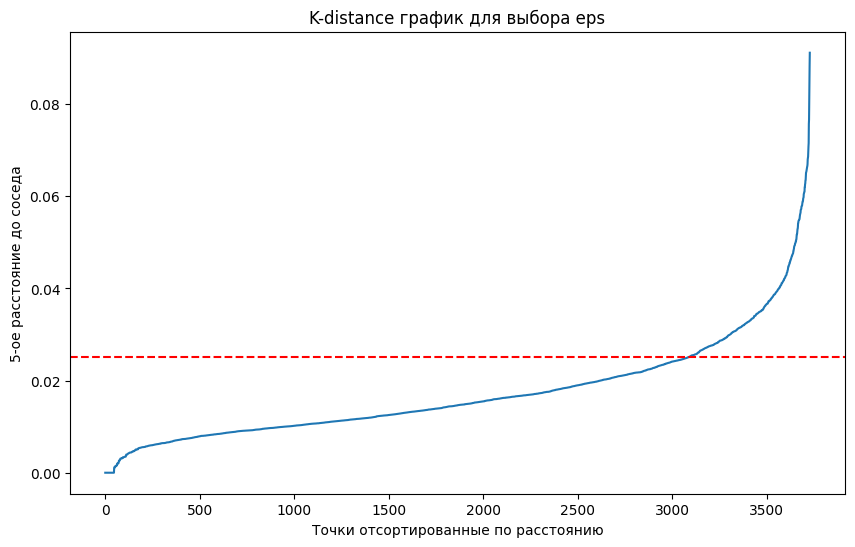


Метрики качества кластеризации:
Average Silhouette Score: 0.916
Calinski-Harabasz Index: 4161261.2
Davies-Bouldin Index: 0.111
Average Within-Cluster Sum of Squares: 0.0


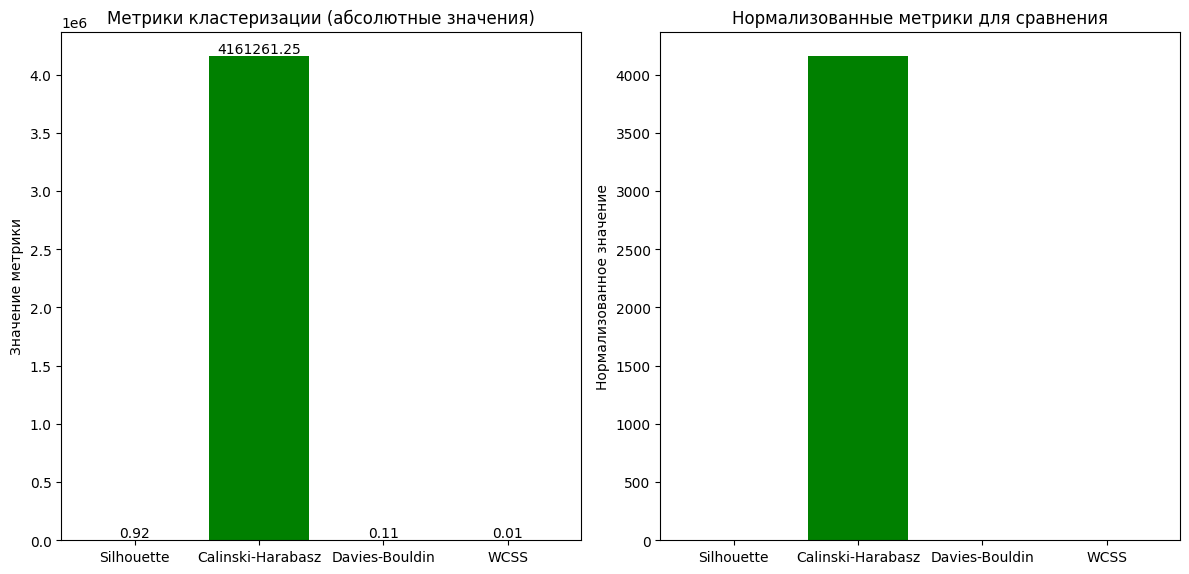

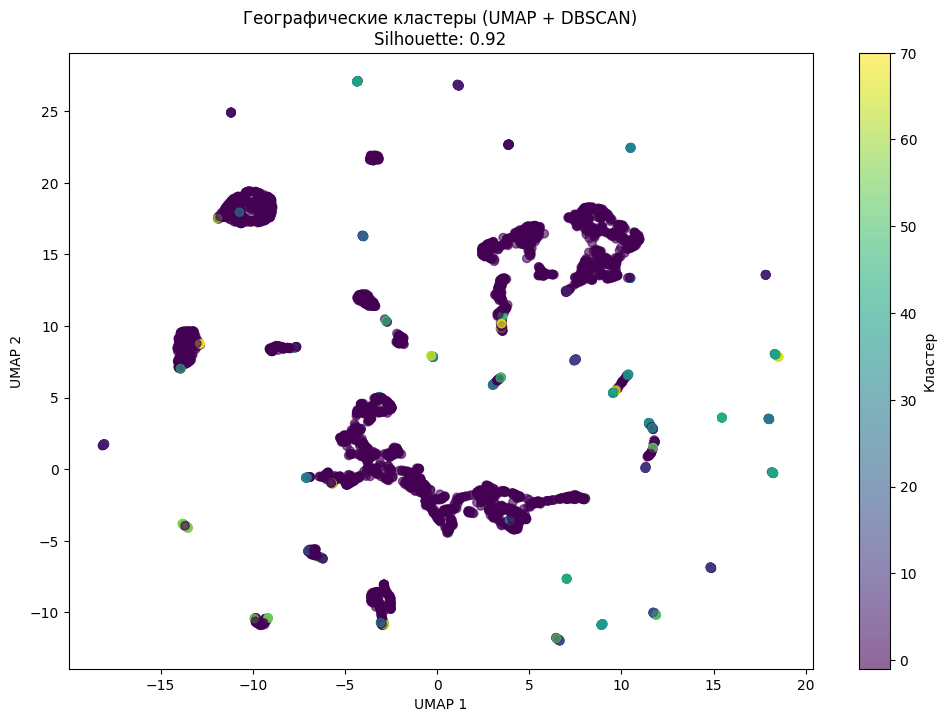


Статистика кластеров:
Всего кластеров: 72
Точек в кластерах: 759
Выбросов (шум): 2970
Кластер 0: 12 точек, средний рейтинг: 1.56
Кластер 1: 21 точек, средний рейтинг: 2.89
Кластер 2: 11 точек, средний рейтинг: 2.85
Кластер 3: 5 точек, средний рейтинг: 2.89
Кластер 4: 10 точек, средний рейтинг: 2.07
Кластер 5: 22 точек, средний рейтинг: 3.02
Кластер 6: 11 точек, средний рейтинг: 1.98
Кластер 7: 19 точек, средний рейтинг: 3.98
Кластер 8: 7 точек, средний рейтинг: 2.95
Кластер 9: 7 точек, средний рейтинг: 1.63
Кластер 10: 10 точек, средний рейтинг: 2.82
Кластер 11: 5 точек, средний рейтинг: 1.95
Кластер 12: 20 точек, средний рейтинг: 2.59
Кластер 13: 19 точек, средний рейтинг: 1.97
Кластер 14: 6 точек, средний рейтинг: 4.52
Кластер 15: 22 точек, средний рейтинг: 4.43
Кластер 16: 19 точек, средний рейтинг: 1.56
Кластер 17: 8 точек, средний рейтинг: 2.66
Кластер 18: 6 точек, средний рейтинг: 3.55
Кластер 19: 8 точек, средний рейтинг: 2.46
Кластер 20: 6 точек, средний рейтинг: 1.60
Кластер 

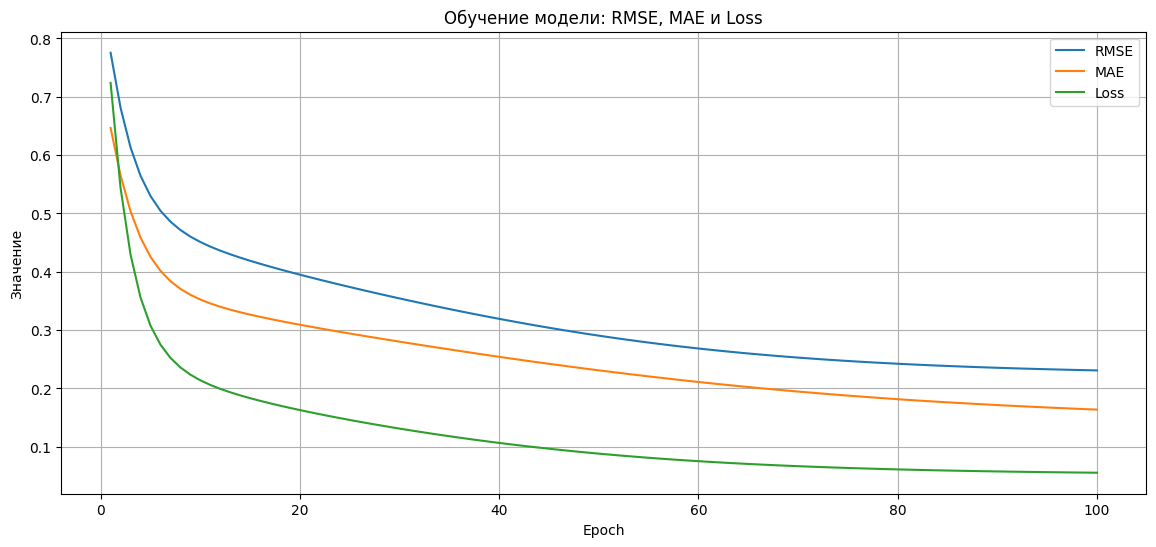

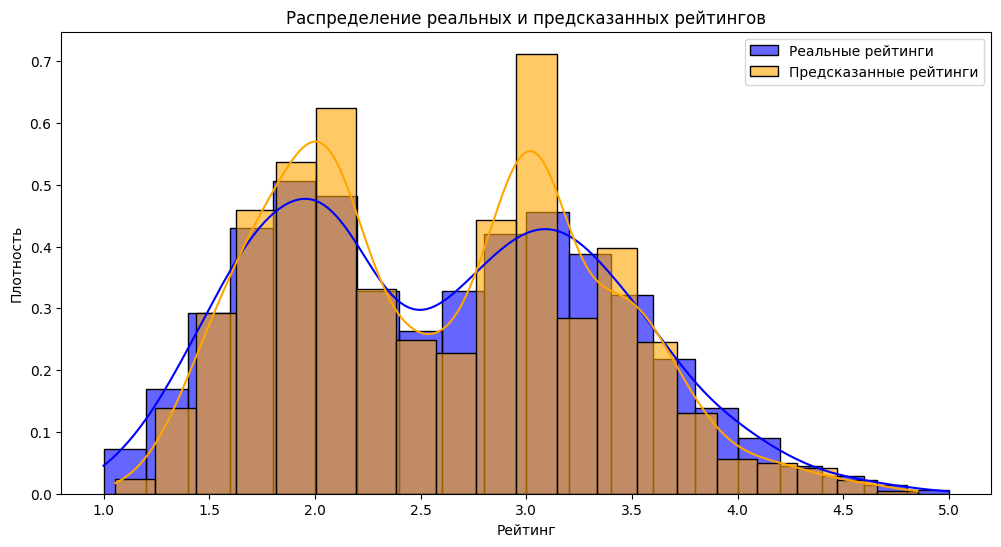

In [49]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
import umap
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from scipy.sparse import csr_matrix

class GeoRecommender:
    def __init__(self, n_factors=50, n_epochs=300, lr=0.01, reg=0.01,
                 dbscan_eps=None, dbscan_min_samples=5, geo_weight=0.5,
                 cultural_weight=0.3, auto_eps_percentile=5, min_eps=0.025,
                 verbose=True):
        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.lr = lr
        self.reg = reg
        self.dbscan_eps = dbscan_eps
        self.dbscan_min_samples = dbscan_min_samples
        self.geo_weight = geo_weight
        self.cultural_weight = cultural_weight
        self.auto_eps_percentile = auto_eps_percentile
        self.min_eps = min_eps
        self.verbose = verbose
        self.cluster_centers = {}
        self.best_factors = None
        self.train_history = []
        self.df_processed = None
        self.cultural_features = None
        self.cultural_svd = None

    def _preprocess_data(self, df):
        # Переименование и обработка географических данных
        df = df.rename(columns={
            '[User ID]': 'user_id',
            '[IP No.]': 'item_id',
            '[Latitude]': 'latitude',
            '[Longitude]': 'longitude'
        })
        # Обработка пропущенных значений
        df['latitude'].fillna(df['latitude'].median(), inplace=True)
        df['longitude'].fillna(df['longitude'].median(), inplace=True)
        # Нормализация координат
        coords = df[['latitude', 'longitude']].values
        self.coord_scaler = StandardScaler()
        df[['lat_norm', 'lon_norm']] = self.coord_scaler.fit_transform(coords)
        # Преобразование ID
        df['user_id'] = pd.factorize(df['user_id'])[0].astype(int)
        df['item_id'] = pd.factorize(df['item_id'])[0].astype(int)
        # Извлечение культурных признаков (пример)
        if 'country' in df.columns:
            cultural_data = pd.get_dummies(df['country'], prefix='culture')
            self.cultural_features = cultural_data.columns.tolist()
            # SVD для культурных признаков
            cultural_sparse = csr_matrix(cultural_data.values)
            self.cultural_svd = TruncatedSVD(n_components=5, random_state=42)
            cultural_reduced = self.cultural_svd.fit_transform(cultural_sparse)
            for i in range(cultural_reduced.shape[1]):
                df[f'cultural_{i}'] = cultural_reduced[:, i]
        # Генерация синтетических рейтингов если нет реальных
        if 'rating' not in df.columns:
            df['rating'] = self._generate_synthetic_ratings(df)
        self.df_processed = df
        return df

    def _generate_synthetic_ratings(self, df):
        np.random.seed(42)
        coords = df[['lat_norm', 'lon_norm']].values
        kmeans = KMeans(n_clusters=10, random_state=42)
        clusters = kmeans.fit_predict(coords)
        base_ratings = np.array([3.5, 2.0, 4.0, 1.5, 3.0, 4.5, 2.5, 3.8, 4.2, 1.8])
        cultural_impact = 0
        if self.cultural_svd is not None:
            cultural_impact = np.sum(df.filter(regex='cultural_').values, axis=1) * 0.2
        ratings = base_ratings[clusters] + np.random.normal(0, 0.3, size=len(df)) + cultural_impact
        return np.clip(ratings, 1, 5)

    def _create_geo_clusters(self, df):
        coords = df[['lat_norm', 'lon_norm']].values
        # Автоматический подбор параметра eps для DBSCAN
        if self.dbscan_eps is None:
            nn = NearestNeighbors(n_neighbors=self.dbscan_min_samples)
            nn.fit(coords)
            dists, _ = nn.kneighbors(coords)
            k_dists = dists[:, -1]
            eps = np.percentile(k_dists, self.auto_eps_percentile)
            self.dbscan_eps = max(eps, self.min_eps)
            # Визуализация K-distance графика
            plt.figure(figsize=(10, 6))
            plt.plot(np.sort(k_dists))
            plt.title('K-distance график для выбора eps')
            plt.xlabel('Точки отсортированные по расстоянию')
            plt.ylabel(f'{self.dbscan_min_samples}-ое расстояние до соседа')
            plt.axhline(y=self.dbscan_eps, color='r', linestyle='--')
            plt.show()
        # UMAP для уменьшения размерности
        reducer = umap.UMAP(n_components=2, random_state=42)
        embedding = reducer.fit_transform(coords)
        # DBSCAN кластеризация
        dbscan = DBSCAN(eps=self.dbscan_eps, min_samples=self.dbscan_min_samples)
        clusters = dbscan.fit_predict(embedding)
        df['geo_cluster'] = clusters
        # Метрики кластеризации (только для нешумовых точек)
        valid_points = clusters != -1
        if sum(valid_points) > 1 and len(np.unique(clusters[valid_points])) > 1:
            silhouette_avg = silhouette_score(embedding[valid_points], clusters[valid_points])
            calinski = calinski_harabasz_score(embedding[valid_points], clusters[valid_points])
            davies = davies_bouldin_score(embedding[valid_points], clusters[valid_points])
            wcss = 0
            for cluster_id in np.unique(clusters[valid_points]):
                cluster_points = embedding[clusters == cluster_id]
                cluster_center = cluster_points.mean(axis=0)
                wcss += ((cluster_points - cluster_center) ** 2).sum()
            avg_wcss = wcss / len(np.unique(clusters[valid_points]))
            print("\nМетрики качества кластеризации:")
            print(f"Average Silhouette Score: {silhouette_avg:.3f}")
            print(f"Calinski-Harabasz Index: {calinski:.1f}")
            print(f"Davies-Bouldin Index: {davies:.3f}")
            print(f"Average Within-Cluster Sum of Squares: {avg_wcss:.1f}")
            self._plot_cluster_metrics(silhouette_avg, calinski, davies, avg_wcss)
        else:
            print("\nНедостаточно кластеров для вычисления метрик")
        # Визуализация кластеров
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, cmap='viridis', alpha=0.6)
        plt.colorbar(scatter, label='Кластер')
        plt.title(f'Географические кластеры (UMAP + DBSCAN)\nSilhouette: {silhouette_avg:.2f}' if 'silhouette_avg' in locals() else 'Географические кластеры')
        plt.xlabel('UMAP 1')
        plt.ylabel('UMAP 2')
        plt.show()
        # Анализ кластеров
        cluster_counts = Counter(clusters)
        print("\nСтатистика кластеров:")
        print(f"Всего кластеров: {len(cluster_counts)}")
        print(f"Точек в кластерах: {sum(cluster_counts.values()) - cluster_counts.get(-1, 0)}")
        print(f"Выбросов (шум): {cluster_counts.get(-1, 0)}")
        centers = {}
        for c in np.unique(clusters):
            if c != -1:
                subset = df[df['geo_cluster'] == c]
                centers[c] = {
                    'center': subset[['lat_norm', 'lon_norm']].mean().values,
                    'size': len(subset),
                    'avg_rating': subset['rating'].mean(),
                    'cultural_features': subset.filter(regex='cultural_').mean().values if self.cultural_features else None
                }
                print(f"Кластер {c}: {len(subset)} точек, средний рейтинг: {subset['rating'].mean():.2f}")
        self.cluster_centers = centers
        return df, centers

    def _plot_cluster_metrics(self, silhouette, calinski, davies, wcss):
        metrics = {
            'Silhouette': silhouette,
            'Calinski-Harabasz': calinski,
            'Davies-Bouldin': davies,
            'WCSS': wcss
        }
        plt.figure(figsize=(12, 6))
        normalized = {
            'Silhouette': silhouette,
            'Calinski-Harabasz': calinski / 1000 if calinski > 1000 else calinski / 100,
            'Davies-Bouldin': davies,
            'WCSS': wcss / 1000 if wcss > 1000 else wcss / 100
        }
        plt.subplot(1, 2, 1)
        bars = plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'red', 'purple'])
        plt.title('Метрики кластеризации (абсолютные значения)')
        plt.ylabel('Значение метрики')
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.2f}',
                     ha='center', va='bottom')
        plt.subplot(1, 2, 2)
        bars_norm = plt.bar(normalized.keys(), normalized.values(), color=['blue', 'green', 'red', 'purple'])
        plt.title('Нормализованные метрики для сравнения')
        plt.ylabel('Нормализованное значение')
        plt.tight_layout()
        plt.show()

    def _init_factors(self, n_users, n_items, n_clusters):
        self.user_factors = np.random.normal(scale=0.1, size=(n_users, self.n_factors))
        self.item_factors = np.random.normal(scale=0.1, size=(n_items, self.n_factors))
        self.user_biases = np.zeros(n_users)
        self.item_biases = np.zeros(n_items)
        self.global_mean = 3.0
        self.geo_cluster_factors = np.random.normal(scale=0.1, size=(n_clusters, self.n_factors))
        self.cluster_weights = np.ones(n_clusters)
        if self.cultural_features:
            n_cultural = len(self.cultural_features)
            self.cultural_user_factors = np.random.normal(scale=0.1, size=(n_users, n_cultural))
            self.cultural_item_factors = np.random.normal(scale=0.1, size=(n_items, n_cultural))

    def _predict_one(self, user, item, cluster):
        user_idx = int(user)
        item_idx = int(item)
        pred = self.global_mean + self.user_biases[user_idx] + self.item_biases[item_idx]
        pred += np.dot(self.user_factors[user_idx], self.item_factors[item_idx])
        if cluster != -1 and cluster in self.cluster_centers:
            cluster_idx = int(cluster)
            geo_impact = np.dot(self.geo_cluster_factors[cluster_idx], self.item_factors[item_idx])
            weight = self.cluster_weights[cluster_idx] / sum(self.cluster_weights)
            pred += geo_impact * self.geo_weight * weight
        if self.cultural_features:
            cultural_impact = np.dot(self.cultural_user_factors[user_idx], self.cultural_item_factors[item_idx])
            pred += cultural_impact * self.cultural_weight
        return np.clip(pred, 1, 5)

    def _update_factors(self, user, item, cluster, err, lr):
        user_idx = int(user)
        item_idx = int(item)
        self.user_biases[user_idx] += lr * (err - self.reg * self.user_biases[user_idx])
        self.item_biases[item_idx] += lr * (err - self.reg * self.item_biases[item_idx])
        grad_u = err * self.item_factors[item_idx] - self.reg * self.user_factors[user_idx]
        grad_i = err * self.user_factors[user_idx] - self.reg * self.item_factors[item_idx]
        self.user_factors[user_idx] += lr * grad_u
        self.item_factors[item_idx] += lr * grad_i
        if cluster != -1 and cluster in self.cluster_centers:
            cluster_idx = int(cluster)
            weight = self.cluster_weights[cluster_idx] / sum(self.cluster_weights)
            grad_geo = err * self.item_factors[item_idx] * self.geo_weight * weight - self.reg * self.geo_cluster_factors[cluster_idx]
            self.geo_cluster_factors[cluster_idx] += lr * grad_geo
        if self.cultural_features:
            grad_cultural_u = err * self.cultural_item_factors[item_idx] * self.cultural_weight - self.reg * self.cultural_user_factors[user_idx]
            grad_cultural_i = err * self.cultural_user_factors[user_idx] * self.cultural_weight - self.reg * self.cultural_item_factors[item_idx]
            self.cultural_user_factors[user_idx] += lr * grad_cultural_u
            self.cultural_item_factors[item_idx] += lr * grad_cultural_i

    def evaluate(self, df):
        preds = [self._predict_one(row['user_id'], row['item_id'], row['geo_cluster']) for _, row in df.iterrows()]
        truths = df['rating'].tolist()
        return {
            'mae': mean_absolute_error(truths, preds),
            'rmse': np.sqrt(mean_squared_error(truths, preds))
        }

    def _plot_rating_distributions(self, df):
        preds = [self._predict_one(row['user_id'], row['item_id'], row['geo_cluster']) for _, row in df.iterrows()]
        truths = df['rating'].tolist()
        plt.figure(figsize=(12, 6))
        sns.histplot(truths, bins=20, color='blue', label='Реальные рейтинги', kde=True, stat='density', alpha=0.6)
        sns.histplot(preds, bins=20, color='orange', label='Предсказанные рейтинги', kde=True, stat='density', alpha=0.6)
        plt.title('Распределение реальных и предсказанных рейтингов')
        plt.xlabel('Рейтинг')
        plt.ylabel('Плотность')
        plt.legend()
        plt.show()

    def fit(self, df):
        # Предобработка данных
        df = self._preprocess_data(df)
        # Геокластеризация
        df, self.cluster_centers = self._create_geo_clusters(df)
        # Инициализация факторов
        n_users = df['user_id'].nunique()
        n_items = df['item_id'].nunique()
        n_clusters = len(self.cluster_centers)
        self._init_factors(n_users, n_items, n_clusters)
        # Обучение модели
        best_rmse = float('inf')
        for epoch in range(self.n_epochs):
            df = df.sample(frac=1).reset_index(drop=True)
            total_loss = 0
            for _, row in df.iterrows():
                user = row['user_id']
                item = row['item_id']
                cluster = row['geo_cluster']
                rating = row['rating']
                pred = self._predict_one(user, item, cluster)
                err = rating - pred
                total_loss += err ** 2
                self._update_factors(user, item, cluster, err, self.lr)
            train_metrics = self.evaluate(df)
            self.train_history.append({
                'epoch': epoch + 1,
                'loss': total_loss/len(df),
                'rmse': train_metrics['rmse'],
                'mae': train_metrics['mae']
            })
            if self.verbose:
                print(f"Epoch {epoch + 1}: Loss = {total_loss/len(df):.4f}, RMSE = {train_metrics['rmse']:.4f}, MAE = {train_metrics['mae']:.4f}")
            if train_metrics['rmse'] < best_rmse:
                best_rmse = train_metrics['rmse']
                self._save_best_factors()
        self._restore_best_factors()
        self._visualize_results()
        self._plot_rating_distributions(self.df_processed)

    def _save_best_factors(self):
        self.best_factors = {
            'user_factors': self.user_factors.copy(),
            'item_factors': self.item_factors.copy(),
            'user_biases': self.user_biases.copy(),
            'item_biases': self.item_biases.copy(),
            'geo_cluster_factors': self.geo_cluster_factors.copy(),
            'cluster_weights': self.cluster_weights.copy(),
            'cultural_user_factors': self.cultural_user_factors.copy() if self.cultural_features else None,
            'cultural_item_factors': self.cultural_item_factors.copy() if self.cultural_features else None
        }

    def _restore_best_factors(self):
        if self.best_factors is not None:
            self.user_factors = self.best_factors['user_factors']
            self.item_factors = self.best_factors['item_factors']
            self.user_biases = self.best_factors['user_biases']
            self.item_biases = self.best_factors['item_biases']
            self.geo_cluster_factors = self.best_factors['geo_cluster_factors']
            self.cluster_weights = self.best_factors['cluster_weights']
            if self.cultural_features:
                self.cultural_user_factors = self.best_factors['cultural_user_factors']
                self.cultural_item_factors = self.best_factors['cultural_item_factors']

    def _visualize_results(self):
        epochs = [h['epoch'] for h in self.train_history]
        rmse = [h['rmse'] for h in self.train_history]
        mae = [h['mae'] for h in self.train_history]
        loss = [h['loss'] for h in self.train_history]
        plt.figure(figsize=(14, 6))
        plt.plot(epochs, rmse, label='RMSE')
        plt.plot(epochs, mae, label='MAE')
        plt.plot(epochs, loss, label='Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Значение')
        plt.title('Обучение модели: RMSE, MAE и Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
df = pd.read_csv('/content/augmented_qos_data.csv')
recommender = GeoRecommender(n_epochs=100, verbose=True)
recommender.fit(df)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


скачивание полученной модели

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
import umap
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from scipy.sparse import csr_matrix
import pickle
from google.colab import files

class GeoRecommender:
    def __init__(self, n_factors=50, n_epochs=300, lr=0.01, reg=0.01,
                 dbscan_eps=None, dbscan_min_samples=5, geo_weight=0.5,
                 cultural_weight=0.3, auto_eps_percentile=5, min_eps=0.1,
                 verbose=True):
        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.lr = lr
        self.reg = reg
        self.dbscan_eps = dbscan_eps
        self.dbscan_min_samples = dbscan_min_samples
        self.geo_weight = geo_weight
        self.cultural_weight = cultural_weight
        self.auto_eps_percentile = auto_eps_percentile
        self.min_eps = min_eps
        self.verbose = verbose
        self.cluster_centers = {}
        self.best_factors = None
        self.train_history = []
        self.df_processed = None
        self.cultural_features = None
        self.cultural_svd = None

    def _preprocess_data(self, df):
        # Переименование и обработка географических данных
        df = df.rename(columns={
            '[User ID]': 'user_id',
            '[IP No.]': 'item_id',
            '[Latitude]': 'latitude',
            '[Longitude]': 'longitude'
        })
        # Обработка пропущенных значений
        df['latitude'].fillna(df['latitude'].median(), inplace=True)
        df['longitude'].fillna(df['longitude'].median(), inplace=True)
        # Нормализация координат
        coords = df[['latitude', 'longitude']].values
        self.coord_scaler = StandardScaler()
        df[['lat_norm', 'lon_norm']] = self.coord_scaler.fit_transform(coords)
        # Преобразование ID
        df['user_id'] = pd.factorize(df['user_id'])[0].astype(int)
        df['item_id'] = pd.factorize(df['item_id'])[0].astype(int)
        # Извлечение культурных признаков (пример)
        if 'country' in df.columns:
            cultural_data = pd.get_dummies(df['country'], prefix='culture')
            self.cultural_features = cultural_data.columns.tolist()
            # SVD для культурных признаков
            cultural_sparse = csr_matrix(cultural_data.values)
            self.cultural_svd = TruncatedSVD(n_components=5, random_state=42)
            cultural_reduced = self.cultural_svd.fit_transform(cultural_sparse)
            for i in range(cultural_reduced.shape[1]):
                df[f'cultural_{i}'] = cultural_reduced[:, i]
        # Генерация синтетических рейтингов если нет реальных
        if 'rating' not in df.columns:
            df['rating'] = self._generate_synthetic_ratings(df)
        self.df_processed = df
        return df

    def _generate_synthetic_ratings(self, df):
        np.random.seed(42)
        coords = df[['lat_norm', 'lon_norm']].values
        kmeans = KMeans(n_clusters=10, random_state=42)
        clusters = kmeans.fit_predict(coords)
        base_ratings = np.array([3.5, 2.0, 4.0, 1.5, 3.0, 4.5, 2.5, 3.8, 4.2, 1.8])
        cultural_impact = 0
        if self.cultural_svd is not None:
            cultural_impact = np.sum(df.filter(regex='cultural_').values, axis=1) * 0.2
        ratings = base_ratings[clusters] + np.random.normal(0, 0.3, size=len(df)) + cultural_impact
        return np.clip(ratings, 1, 5)

    def _create_geo_clusters(self, df):
        coords = df[['lat_norm', 'lon_norm']].values
        # Автоматический подбор параметра eps для DBSCAN
        if self.dbscan_eps is None:
            nn = NearestNeighbors(n_neighbors=self.dbscan_min_samples)
            nn.fit(coords)
            dists, _ = nn.kneighbors(coords)
            k_dists = dists[:, -1]
            eps = np.percentile(k_dists, self.auto_eps_percentile)
            self.dbscan_eps = max(eps, self.min_eps)
            # Визуализация K-distance графика
            plt.figure(figsize=(10, 6))
            plt.plot(np.sort(k_dists))
            plt.title('K-distance график для выбора eps')
            plt.xlabel('Точки отсортированные по расстоянию')
            plt.ylabel(f'{self.dbscan_min_samples}-ое расстояние до соседа')
            plt.axhline(y=self.dbscan_eps, color='r', linestyle='--')
            plt.show()
        # UMAP для уменьшения размерности
        reducer = umap.UMAP(n_components=2, random_state=42)
        embedding = reducer.fit_transform(coords)
        # DBSCAN кластеризация
        dbscan = DBSCAN(eps=self.dbscan_eps, min_samples=self.dbscan_min_samples)
        clusters = dbscan.fit_predict(embedding)
        df['geo_cluster'] = clusters
        # Метрики кластеризации (только для нешумовых точек)
        valid_points = clusters != -1
        if sum(valid_points) > 1 and len(np.unique(clusters[valid_points])) > 1:
            silhouette_avg = silhouette_score(embedding[valid_points], clusters[valid_points])
            calinski = calinski_harabasz_score(embedding[valid_points], clusters[valid_points])
            davies = davies_bouldin_score(embedding[valid_points], clusters[valid_points])
            wcss = 0
            for cluster_id in np.unique(clusters[valid_points]):
                cluster_points = embedding[clusters == cluster_id]
                cluster_center = cluster_points.mean(axis=0)
                wcss += ((cluster_points - cluster_center) ** 2).sum()
            avg_wcss = wcss / len(np.unique(clusters[valid_points]))
            print("\nМетрики качества кластеризации:")
            print(f"Average Silhouette Score: {silhouette_avg:.3f}")
            print(f"Calinski-Harabasz Index: {calinski:.1f}")
            print(f"Davies-Bouldin Index: {davies:.3f}")
            print(f"Average Within-Cluster Sum of Squares: {avg_wcss:.1f}")
            self._plot_cluster_metrics(silhouette_avg, calinski, davies, avg_wcss)
        else:
            print("\nНедостаточно кластеров для вычисления метрик")
        # Визуализация кластеров
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, cmap='viridis', alpha=0.6)
        plt.colorbar(scatter, label='Кластер')
        plt.title(f'Географические кластеры (UMAP + DBSCAN)\nSilhouette: {silhouette_avg:.2f}' if 'silhouette_avg' in locals() else 'Географические кластеры')
        plt.xlabel('UMAP 1')
        plt.ylabel('UMAP 2')
        plt.show()
        # Анализ кластеров
        cluster_counts = Counter(clusters)
        print("\nСтатистика кластеров:")
        print(f"Всего кластеров: {len(cluster_counts)}")
        print(f"Точек в кластерах: {sum(cluster_counts.values()) - cluster_counts.get(-1, 0)}")
        print(f"Выбросов (шум): {cluster_counts.get(-1, 0)}")
        centers = {}
        for c in np.unique(clusters):
            if c != -1:
                subset = df[df['geo_cluster'] == c]
                centers[c] = {
                    'center': subset[['lat_norm', 'lon_norm']].mean().values,
                    'size': len(subset),
                    'avg_rating': subset['rating'].mean(),
                    'cultural_features': subset.filter(regex='cultural_').mean().values if self.cultural_features else None
                }
                print(f"Кластер {c}: {len(subset)} точек, средний рейтинг: {subset['rating'].mean():.2f}")
        self.cluster_centers = centers
        return df, centers

    def _plot_cluster_metrics(self, silhouette, calinski, davies, wcss):
        metrics = {
            'Silhouette': silhouette,
            'Calinski-Harabasz': calinski,
            'Davies-Bouldin': davies,
            'WCSS': wcss
        }
        plt.figure(figsize=(12, 6))
        normalized = {
            'Silhouette': silhouette,
            'Calinski-Harabasz': calinski / 1000 if calinski > 1000 else calinski / 100,
            'Davies-Bouldin': davies,
            'WCSS': wcss / 1000 if wcss > 1000 else wcss / 100
        }
        plt.subplot(1, 2, 1)
        bars = plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'red', 'purple'])
        plt.title('Метрики кластеризации (абсолютные значения)')
        plt.ylabel('Значение метрики')
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.2f}',
                     ha='center', va='bottom')
        plt.subplot(1, 2, 2)
        bars_norm = plt.bar(normalized.keys(), normalized.values(), color=['blue', 'green', 'red', 'purple'])
        plt.title('Нормализованные метрики для сравнения')
        plt.ylabel('Нормализованное значение')
        plt.tight_layout()
        plt.show()

    def _init_factors(self, n_users, n_items, n_clusters):
        self.user_factors = np.random.normal(scale=0.1, size=(n_users, self.n_factors))
        self.item_factors = np.random.normal(scale=0.1, size=(n_items, self.n_factors))
        self.user_biases = np.zeros(n_users)
        self.item_biases = np.zeros(n_items)
        self.global_mean = 3.0
        self.geo_cluster_factors = np.random.normal(scale=0.1, size=(n_clusters, self.n_factors))
        self.cluster_weights = np.ones(n_clusters)
        if self.cultural_features:
            n_cultural = len(self.cultural_features)
            self.cultural_user_factors = np.random.normal(scale=0.1, size=(n_users, n_cultural))
            self.cultural_item_factors = np.random.normal(scale=0.1, size=(n_items, n_cultural))

    def _predict_one(self, user, item, cluster):
        user_idx = int(user)
        item_idx = int(item)
        pred = self.global_mean + self.user_biases[user_idx] + self.item_biases[item_idx]
        pred += np.dot(self.user_factors[user_idx], self.item_factors[item_idx])
        if cluster != -1 and cluster in self.cluster_centers:
            cluster_idx = int(cluster)
            geo_impact = np.dot(self.geo_cluster_factors[cluster_idx], self.item_factors[item_idx])
            weight = self.cluster_weights[cluster_idx] / sum(self.cluster_weights)
            pred += geo_impact * self.geo_weight * weight
        if self.cultural_features:
            cultural_impact = np.dot(self.cultural_user_factors[user_idx], self.cultural_item_factors[item_idx])
            pred += cultural_impact * self.cultural_weight
        return np.clip(pred, 1, 5)

    def _update_factors(self, user, item, cluster, err, lr):
        user_idx = int(user)
        item_idx = int(item)
        self.user_biases[user_idx] += lr * (err - self.reg * self.user_biases[user_idx])
        self.item_biases[item_idx] += lr * (err - self.reg * self.item_biases[item_idx])
        grad_u = err * self.item_factors[item_idx] - self.reg * self.user_factors[user_idx]
        grad_i = err * self.user_factors[user_idx] - self.reg * self.item_factors[item_idx]
        self.user_factors[user_idx] += lr * grad_u
        self.item_factors[item_idx] += lr * grad_i
        if cluster != -1 and cluster in self.cluster_centers:
            cluster_idx = int(cluster)
            weight = self.cluster_weights[cluster_idx] / sum(self.cluster_weights)
            grad_geo = err * self.item_factors[item_idx] * self.geo_weight * weight - self.reg * self.geo_cluster_factors[cluster_idx]
            self.geo_cluster_factors[cluster_idx] += lr * grad_geo
        if self.cultural_features:
            grad_cultural_u = err * self.cultural_item_factors[item_idx] * self.cultural_weight - self.reg * self.cultural_user_factors[user_idx]
            grad_cultural_i = err * self.cultural_user_factors[user_idx] * self.cultural_weight - self.reg * self.cultural_item_factors[item_idx]
            self.cultural_user_factors[user_idx] += lr * grad_cultural_u
            self.cultural_item_factors[item_idx] += lr * grad_cultural_i

    def evaluate(self, df):
        preds = [self._predict_one(row['user_id'], row['item_id'], row['geo_cluster']) for _, row in df.iterrows()]
        truths = df['rating'].tolist()
        return {
            'mae': mean_absolute_error(truths, preds),
            'rmse': np.sqrt(mean_squared_error(truths, preds))
        }

    def _plot_rating_distributions(self, df):
        preds = [self._predict_one(row['user_id'], row['item_id'], row['geo_cluster']) for _, row in df.iterrows()]
        truths = df['rating'].tolist()
        plt.figure(figsize=(12, 6))
        sns.histplot(truths, bins=20, color='blue', label='Реальные рейтинги', kde=True, stat='density', alpha=0.6)
        sns.histplot(preds, bins=20, color='orange', label='Предсказанные рейтинги', kde=True, stat='density', alpha=0.6)
        plt.title('Распределение реальных и предсказанных рейтингов')
        plt.xlabel('Рейтинг')
        plt.ylabel('Плотность')
        plt.legend()
        plt.show()

    def fit(self, df):
        # Предобработка данных
        df = self._preprocess_data(df)
        # Геокластеризация
        df, self.cluster_centers = self._create_geo_clusters(df)
        # Инициализация факторов
        n_users = df['user_id'].nunique()
        n_items = df['item_id'].nunique()
        n_clusters = len(self.cluster_centers)
        self._init_factors(n_users, n_items, n_clusters)
        # Обучение модели
        best_rmse = float('inf')
        for epoch in range(self.n_epochs):
            df = df.sample(frac=1).reset_index(drop=True)
            total_loss = 0
            for _, row in df.iterrows():
                user = row['user_id']
                item = row['item_id']
                cluster = row['geo_cluster']
                rating = row['rating']
                pred = self._predict_one(user, item, cluster)
                err = rating - pred
                total_loss += err ** 2
                self._update_factors(user, item, cluster, err, self.lr)
            train_metrics = self.evaluate(df)
            self.train_history.append({
                'epoch': epoch + 1,
                'loss': total_loss/len(df),
                'rmse': train_metrics['rmse'],
                'mae': train_metrics['mae']
            })
            if self.verbose:
                print(f"Epoch {epoch + 1}: Loss = {total_loss/len(df):.4f}, RMSE = {train_metrics['rmse']:.4f}, MAE = {train_metrics['mae']:.4f}")
            if train_metrics['rmse'] < best_rmse:
                best_rmse = train_metrics['rmse']
                self._save_best_factors()
        self._restore_best_factors()
        self._visualize_results()
        self._plot_rating_distributions(self.df_processed)

    def _save_best_factors(self):
        self.best_factors = {
            'user_factors': self.user_factors.copy(),
            'item_factors': self.item_factors.copy(),
            'user_biases': self.user_biases.copy(),
            'item_biases': self.item_biases.copy(),
            'geo_cluster_factors': self.geo_cluster_factors.copy(),
            'cluster_weights': self.cluster_weights.copy(),
            'cultural_user_factors': self.cultural_user_factors.copy() if self.cultural_features else None,
            'cultural_item_factors': self.cultural_item_factors.copy() if self.cultural_features else None
        }

    def _restore_best_factors(self):
        if self.best_factors is not None:
            self.user_factors = self.best_factors['user_factors']
            self.item_factors = self.best_factors['item_factors']
            self.user_biases = self.best_factors['user_biases']
            self.item_biases = self.best_factors['item_biases']
            self.geo_cluster_factors = self.best_factors['geo_cluster_factors']
            self.cluster_weights = self.best_factors['cluster_weights']
            if self.cultural_features:
                self.cultural_user_factors = self.best_factors['cultural_user_factors']
                self.cultural_item_factors = self.best_factors['cultural_item_factors']

    def _visualize_results(self):
        epochs = [h['epoch'] for h in self.train_history]
        rmse = [h['rmse'] for h in self.train_history]
        mae = [h['mae'] for h in self.train_history]
        loss = [h['loss'] for h in self.train_history]
        plt.figure(figsize=(14, 6))
        plt.plot(epochs, rmse, label='RMSE')
        plt.plot(epochs, mae, label='MAE')
        plt.plot(epochs, loss, label='Loss (MSE)')
        plt.xlabel('Epoch')
        plt.ylabel('Значение')
        plt.title('Обучение модели: RMSE, MAE и Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def save_model(self, filepath):
        """Сохраняет модель в файл с помощью pickle."""
        with open(filepath, 'wb') as f:
            pickle.dump(self.__dict__, f)

    @staticmethod
    def load_model(filepath):
        """Загружает модель из файла."""
        with open(filepath, 'rb') as f:
            model = GeoRecommender(verbose=False)  # Создаём экземпляр
            model.__dict__ = pickle.load(f)
        return model

    def get_model_summary(self):
        """Возвращает текстовый отчёт о модели."""
        summary = [
            f"Модель GeoRecommender (n_factors={self.n_factors})",
            f"Лучший RMSE: {min([h['rmse'] for h in self.train_history]):.4f}",
            f"Количество кластеров: {len(self.cluster_centers)}",
            f"Размеры факторов:",
            f"  user_factors: {self.user_factors.shape}",
            f"  item_factors: {self.item_factors.shape}",
            f"  geo_cluster_factors: {self.geo_cluster_factors.shape}",
        ]
        if self.cultural_features:
            summary.append(f"  cultural_factors: {self.cultural_user_factors.shape[1]} компонент")
        return "\n".join(summary)

# Пример использования:
if __name__ == "__main__":
    # Загрузка данных
    df = pd.read_csv('/content/cleaned_qos_data.csv')

    # Обучение модели
    recommender = GeoRecommender(n_epochs=100, verbose=True)
    recommender.fit(df)

    # Сохранение модели
    recommender.save_model('/content/geo_recommender_model.pkl')

    # Вывод информации о модели
    print(recommender.get_model_summary())

    # Скачивание модели на компьютер
    files.download('/content/geo_recommender_model.pkl')

развертывание MVP при помощи Streamlit

In [ ]:
from google.colab import files
files.download('/content/geo_recommender_model.pkl')

In [ ]:
!pip install streamlit

In [ ]:
from google.colab import files

# Содержимое файла app.py
app_py_content = """
import streamlit as st
import pandas as pd
import numpy as np
import joblib
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка модели и данных
@st.cache_resource
def load_model():
    df = pd.read_csv('/content/cleaned_qos_data.csv')  # или загрузка из другого источника
    recommender = GeoRecommender(n_epochs=100, verbose=False)
    recommender.fit(df)
    return recommender
    return joblib.load('/content/geo_recommender_model.pkl')

model = load_model()

# Интерфейс Streamlit
st.title("Гибридный подход матричной факторизации с интеграцией географических координат и культурных характеристик пользователей.")
st.markdown(\"""
Анализ географических данных и предсказание рейтингов на основе местоположения
\""")

# Основные вкладки
tab1, tab2, tab3 = st.tabs(["Предсказание", "Визуализация", "О модели"])

with tab1:
    st.header("Предсказание рейтинга")

    # Создаем форму для ввода данных
    with st.form("prediction_form"):
        col1, col2 = st.columns(2)

        with col1:
            user_id = st.text_input("User ID", "user123")
            latitude = st.number_input("Широта", value=55.751244)

        with col2:
            item_id = st.text_input("Item ID", "item456")
            longitude = st.number_input("Долгота", value=37.618423)

        submitted = st.form_submit_button("Предсказать рейтинг")

    if submitted:
        # Создаем временный DataFrame для предсказания
        input_data = pd.DataFrame({
            '[User ID]': [user_id],
            '[IP No.]': [item_id],
            '[Latitude]': [latitude],
            '[Longitude]': [longitude]
        })

        # Обрабатываем данные и делаем предсказание
        processed_data = model._preprocess_data(input_data)
        prediction = model._predict_one(
            processed_data.iloc[0]['user_id'],
            processed_data.iloc[0]['item_id'],
            processed_data.iloc[0]['geo_cluster']
        )

        st.success(f"Предсказанный рейтинг: **{prediction:.2f}**")

        # Показываем дополнительные метрики
        with st.expander("Детали предсказания"):
            st.write(f"Географический кластер: {processed_data.iloc[0]['geo_cluster']}")
            if model.cultural_features:
                st.write("Культурные факторы:")
                cultural_factors = processed_data.filter(regex='cultural_').iloc[0]
                st.write(cultural_factors)

with tab2:
    st.header("Визуализация данных")

    # Показываем графики из модели
    if hasattr(model, 'train_history'):
        st.subheader("График обучения")
        fig, ax = plt.subplots(figsize=(10, 5))
        epochs = [h['epoch'] for h in model.train_history]
        ax.plot(epochs, [h['rmse'] for h in model.train_history], label='RMSE')
        ax.plot(epochs, [h['mae'] for h in model.train_history], label='MAE')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Значение')
        ax.legend()
        ax.grid(True)
        st.pyplot(fig)

    # Показываем распределение рейтингов
    if model.df_processed is not None:
        st.subheader("Распределение рейтингов")
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.histplot(model.df_processed['rating'], bins=20, kde=True, ax=ax)
        ax.set_title('Распределение рейтингов в данных')
        st.pyplot(fig)

with tab3:
    st.header("Информация о модели")
    st.markdown(\"""
    ### Параметры модели:
    - Географический вес: {model.geo_weight}
    - Культурный вес: {model.cultural_weight}
    - Количество факторов: {model.n_factors}
    - Количество эпох обучения: {model.n_epochs}
    \""")

    st.subheader("Метрики кластеризации")
    if model.cluster_centers:
        st.write(f"Всего кластеров: {len(model.cluster_centers)}")
        st.write(f"Размеры кластеров:")
        cluster_sizes = {k: v['size'] for k, v in model.cluster_centers.items()}
        st.bar_chart(cluster_sizes)

# Загрузка своих данных
st.sidebar.header("Загрузите свои данные")
uploaded_file = st.sidebar.file_uploader("Выберите CSV файл", type="csv")

if uploaded_file is not None:
    try:
        user_data = pd.read_csv(uploaded_file)
        st.sidebar.success("Данные успешно загружены!")

        if st.sidebar.button("Обучить модель на новых данных"):
            with st.spinner('Обучение модели...'):
                new_model = GeoRecommender(n_epochs=50, verbose=False)
                new_model.fit(user_data)
                model = new_model
                st.success("Модель успешно переобучена!")

                # Сохранение модели (опционально)
                buffer = BytesIO()
                joblib.dump(model, buffer)
                st.sidebar.download_button(
                    label="Скачать модель",
                    data=buffer,
                    file_name="/content/geo_recommender_model.pkl",
                    mime="application/octet-stream"
                )
    except Exception as e:
        st.sidebar.error(f"Ошибка при загрузке файла: {e}")
"""

# Создаем файл в Colab
with open('app.py', 'w') as f:
    f.write(app_py_content)

# Скачиваем файл на компьютер
files.download('app.py')

In [ ]:
!pip install joblib

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import pickle
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка модели и данных
@st.cache_resource
def load_model():
    df = pd.read_csv('/content/cleaned_qos_data.csv')  # или загрузка из другого источника
    recommender = GeoRecommender(n_epochs=100, verbose=False)
    recommender.fit(df)
    return recommender

model = load_model()

# Интерфейс Streamlit
st.title("Гибридный подход матричной факторизации с интеграцией  географических координат и культурных характеристик пользователей.")
st.markdown("""
Анализ географических данных и предсказание рейтингов на основе местоположения
""")

# Основные вкладки
tab1, tab2, tab3 = st.tabs(["Предсказание", "Визуализация", "О модели"])

with tab1:
    st.header("Предсказание рейтинга")

    # Создаем форму для ввода данных
    with st.form("prediction_form"):
        col1, col2 = st.columns(2)

        with col1:
            user_id = st.text_input("User ID", "user123")
            latitude = st.number_input("Широта", value=55.751244)

        with col2:
            item_id = st.text_input("Item ID", "item456")
            longitude = st.number_input("Долгота", value=37.618423)

        submitted = st.form_submit_button("Предсказать рейтинг")

    if submitted:
        # Создаем временный DataFrame для предсказания
        input_data = pd.DataFrame({
            '[User ID]': [user_id],
            '[IP No.]': [item_id],
            '[Latitude]': [latitude],
            '[Longitude]': [longitude]
        })

        # Обрабатываем данные и делаем предсказание
        processed_data = model._preprocess_data(input_data)
        prediction = model._predict_one(
            processed_data.iloc[0]['user_id'],
            processed_data.iloc[0]['item_id'],
            processed_data.iloc[0]['geo_cluster']
        )

        st.success(f"Предсказанный рейтинг: **{prediction:.2f}**")

        # Показываем дополнительные метрики
        with st.expander("Детали предсказания"):
            st.write(f"Географический кластер: {processed_data.iloc[0]['geo_cluster']}")
            if model.cultural_features:
                st.write("Культурные факторы:")
                cultural_factors = processed_data.filter(regex='cultural_').iloc[0]
                st.write(cultural_factors)

with tab2:
    st.header("Визуализация данных")

    # Показываем графики из модели
    if hasattr(model, 'train_history'):
        st.subheader("График обучения")
        fig, ax = plt.subplots(figsize=(10, 5))
        epochs = [h['epoch'] for h in model.train_history]
        ax.plot(epochs, [h['rmse'] for h in model.train_history], label='RMSE')
        ax.plot(epochs, [h['mae'] for h in model.train_history], label='MAE')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Значение')
        ax.legend()
        ax.grid(True)
        st.pyplot(fig)

    # Показываем распределение рейтингов
    if model.df_processed is not None:
        st.subheader("Распределение рейтингов")
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.histplot(model.df_processed['rating'], bins=20, kde=True, ax=ax)
        ax.set_title('Распределение рейтингов в данных')
        st.pyplot(fig)

with tab3:
    st.header("Информация о модели")
    st.markdown("""
    ### Параметры модели:
    - Географический вес: {model.geo_weight}
    - Культурный вес: {model.cultural_weight}
    - Количество факторов: {model.n_factors}
    - Количество эпох обучения: {model.n_epochs}
    """)

    st.subheader("Метрики кластеризации")
    if model.cluster_centers:
        st.write(f"Всего кластеров: {len(model.cluster_centers)}")
        st.write(f"Размеры кластеров:")
        cluster_sizes = {k: v['size'] for k, v in model.cluster_centers.items()}
        st.bar_chart(cluster_sizes)

# Загрузка своих данных
st.sidebar.header("Загрузите свои данные")
uploaded_file = st.sidebar.file_uploader("Выберите CSV файл", type="csv")

if uploaded_file is not None:
    try:
        user_data = pd.read_csv(uploaded_file)
        st.sidebar.success("Данные успешно загружены!")

        if st.sidebar.button("Обучить модель на новых данных"):
            with st.spinner('Обучение модели...'):
                new_model = GeoRecommender(n_epochs=50, verbose=False)
                new_model.fit(user_data)
                model = new_model
                st.success("Модель успешно переобучена!")

                # Сохранение модели (опционально)
                buffer = BytesIO()
                joblib.dump(model, buffer)
                st.sidebar.download_button(
                    label="Скачать модель",
                    data=buffer,
                    file_name="/content/geo_recommender_model.pkl",
                    mime="application/octet-stream"
                )
    except Exception as e:
        st.sidebar.error(f"Ошибка при загрузке файла: {e}")

with open('app3.py', 'w') as f:
    f.write(app_py_content)
files.download('app3.py')